# Splitting, Augmenting on Training Data, Feature Extractor

In [1]:
# Improved Medical Image Classification with Proper Data Handling

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import VGG16
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit
from PIL import Image
import shutil
import pickle
import gc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import label_binarize, StandardScaler
import seaborn as sns
import pandas as pd

# ========================================================================================
# IMPROVED SECTION 1: ROBUST DATA SPLITTING WITH STRATIFICATION
# ========================================================================================

def analyze_dataset_distribution(original_path):
    """
    Analyze the dataset to understand class distribution before splitting
    """
    diseases = ['Monkeypox', 'Pemphigus', 'Seborrheic keratosis', 'Squamous cell carcinoma']
    class_counts = {}
    
    print("Dataset Analysis:")
    print("=" * 50)
    
    for disease in diseases:
        disease_dir = os.path.join(original_path, disease)
        if os.path.exists(disease_dir):
            image_files = [f for f in os.listdir(disease_dir) 
                          if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))]
            class_counts[disease] = len(image_files)
            print(f"{disease}: {len(image_files)} images")
        else:
            class_counts[disease] = 0
            print(f"{disease}: Directory not found")
    
    print("=" * 50)
    
    # Check minimum requirements
    min_samples = min(class_counts.values())
    print(f"Minimum samples per class: {min_samples}")
    
    if min_samples < 10:
        print("WARNING: Some classes have very few samples. Consider:")
        print("1. Collecting more data")
        print("2. Using a smaller test_size")
        print("3. Combining similar classes")
    
    return class_counts

def split_original_dataset(original_path, train_path, test_path, test_size=0.2, min_test_samples=2):
    """
    Split original dataset BEFORE augmentation to avoid data leakage
    Uses stratified splitting with minimum test samples guarantee
    """
    diseases = ['Monkeypox', 'Pemphigus', 'Seborrheic keratosis', 'Squamous cell carcinoma']
    
    # First, analyze the distribution
    class_counts = analyze_dataset_distribution(original_path)
    
    # Collect all files with their labels
    all_files = []
    all_labels = []
    
    for disease in diseases:
        disease_dir = os.path.join(original_path, disease)
        if not os.path.exists(disease_dir):
            continue
            
        image_files = [f for f in os.listdir(disease_dir) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))]
        
        # Check if we have enough samples for meaningful split
        if len(image_files) < (min_test_samples + 1):
            print(f"Warning: {disease} has only {len(image_files)} images")
            print(f"Need at least {min_test_samples + 1} for proper train/test split")
            
            # If very few samples, put most in training, at least 1 in test
            if len(image_files) >= 2:
                test_count = max(1, len(image_files) // 4)  # At least 1, max 25%
            else:
                test_count = 0
                print(f"Skipping {disease} - insufficient data")
                continue
        else:
            # Calculate test count ensuring minimum samples
            test_count = max(min_test_samples, int(len(image_files) * test_size))
        
        # Add to collection
        for img_file in image_files:
            all_files.append((disease, img_file))
            all_labels.append(disease)
    
    if not all_files:
        raise ValueError("No valid image files found in any class directory")
    
    # Convert to arrays for stratified split
    all_files = np.array(all_files)
    all_labels = np.array(all_labels)
    
    # Use StratifiedShuffleSplit for better control
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    
    try:
        train_idx, test_idx = next(sss.split(all_files, all_labels))
    except ValueError as e:
        print(f"Stratified split failed: {e}")
        print("Falling back to simple random split...")
        # Fallback to simple split
        indices = np.arange(len(all_files))
        np.random.seed(42)
        np.random.shuffle(indices)
        split_point = int(len(indices) * (1 - test_size))
        train_idx = indices[:split_point]
        test_idx = indices[split_point:]
    
    train_files = all_files[train_idx]
    test_files = all_files[test_idx]
    
    # Create directories and copy files
    for disease in diseases:
        os.makedirs(os.path.join(train_path, disease), exist_ok=True)
        os.makedirs(os.path.join(test_path, disease), exist_ok=True)
    
    # Copy training files
    train_counts = {disease: 0 for disease in diseases}
    for disease, img_file in train_files:
        src = os.path.join(original_path, disease, img_file)
        dst = os.path.join(train_path, disease, img_file)
        shutil.copy2(src, dst)
        train_counts[disease] += 1
    
    # Copy test files
    test_counts = {disease: 0 for disease in diseases}
    for disease, img_file in test_files:
        src = os.path.join(original_path, disease, img_file)
        dst = os.path.join(test_path, disease, img_file)
        shutil.copy2(src, dst)
        test_counts[disease] += 1
    
    # Print results
    print("\nDataset Split Results:")
    print("=" * 50)
    for disease in diseases:
        if train_counts[disease] > 0 or test_counts[disease] > 0:
            print(f"{disease}: {train_counts[disease]} train, {test_counts[disease]} test")
        else:
            print(f"{disease}: No samples found")
    
    # Verify all classes have test samples
    missing_test_classes = [d for d in diseases if test_counts[d] == 0 and train_counts[d] > 0]
    if missing_test_classes:
        print(f"\nWARNING: Classes with no test samples: {missing_test_classes}")
        print("This will cause issues with evaluation metrics.")
        return False
    
    print("\n✓ All classes have samples in both train and test sets!")
    return True

# ========================================================================================
# IMPROVED SECTION 2: AUGMENT ONLY TRAINING DATA
# ========================================================================================

def augment_training_data(train_path, augmented_train_path, target_per_class = 200):
    """
    Augment only the training data to balance classes
    Reduced target to avoid overfitting with small datasets
    """
    diseases = ['Monkeypox', 'Pemphigus', 'Seborrheic keratosis', 'Squamous cell carcinoma']
    
    augmenter = ImageDataGenerator(
        rotation_range=15,          # Reduced from 20
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.15,           # Reduced from 0.2
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],  # Added brightness variation
        fill_mode='nearest'
    )
    
    for disease in diseases:
        input_dir = os.path.join(train_path, disease)
        output_dir = os.path.join(augmented_train_path, disease)
        os.makedirs(output_dir, exist_ok=True)
        
        if not os.path.exists(input_dir):
            continue
            
        image_files = [f for f in os.listdir(input_dir) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))]
        
        if not image_files:
            continue
        
        # Copy original images
        for img_file in image_files:
            shutil.copy2(os.path.join(input_dir, img_file), 
                        os.path.join(output_dir, img_file))
        
        # Calculate augmentation needed
        current_count = len(image_files)

        # print("test---------- ",target_per_class)
        
        # Adjust target based on current count to avoid extreme augmentation
        adjusted_target = min(target_per_class, current_count * 5)  # Max 5x augmentation
        
        
        if current_count >= adjusted_target:
            print(f"{disease}: {current_count} images (no augmentation needed)")
            continue
            
        extra_needed = adjusted_target - current_count
        augs_per_image = max(1, extra_needed // current_count)
        
        print(f"{disease}: Augmenting {current_count} → {adjusted_target} images ({augs_per_image} augs per image)")
        
        count = 0
        for img_file in image_files:
            if count >= extra_needed:
                break
                
            img_path = os.path.join(input_dir, img_file)
            try:
                img = load_img(img_path, target_size=(224, 224))
                x = img_to_array(img)
                x = np.expand_dims(x, axis=0)
                
                aug_iter = augmenter.flow(x, batch_size=1, seed=42)
                
                for j in range(augs_per_image):
                    if count >= extra_needed:
                        break
                    
                    aug_img = next(aug_iter)[0].astype('uint8')
                    aug_pil = Image.fromarray(aug_img)
                    
                    base_name = os.path.splitext(img_file)[0]
                    aug_name = f"{base_name}_aug_{j+1}.jpg"
                    aug_path = os.path.join(output_dir, aug_name)
                    
                    aug_pil.save(aug_path, 'JPEG', quality=95)
                    count += 1
                    
            except Exception as e:
                print(f"Error augmenting {img_file}: {e}")
                
        final_count = len(os.listdir(output_dir))
        print(f"{disease}: Final count: {final_count} images")

# ========================================================================================
# IMPROVED SECTION 3: MEMORY-EFFICIENT FEATURE EXTRACTION
# ========================================================================================


# VGG 16

# class FeatureExtractor:
#     def __init__(self):
#         self.base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        
#     def extract_features_batch(self, directory, batch_size=16):  # Reduced batch size
#         """
#         Extract features in batches to manage memory efficiently
#         """
#         features = []
#         labels = []
        
#         diseases = ['Monkeypox', 'Pemphigus', 'Seborrheic keratosis', 'Squamous cell carcinoma']
        
#         for class_name in diseases:
#             class_dir = os.path.join(directory, class_name)
#             if not os.path.exists(class_dir):
#                 continue
                
#             image_files = [f for f in os.listdir(class_dir) 
#                           if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))]
            
#             if not image_files:
#                 print(f"No images found in {class_name}")
#                 continue
            
#             print(f"Processing {len(image_files)} images from {class_name}...")
            
#             # Process in batches
#             for i in range(0, len(image_files), batch_size):
#                 batch_files = image_files[i:i+batch_size]
#                 batch_images = []
#                 batch_labels = []
                
#                 for img_file in batch_files:
#                     img_path = os.path.join(class_dir, img_file)
#                     try:
#                         img = load_img(img_path, target_size=(224, 224))
#                         x = img_to_array(img)
#                         x = tf.keras.applications.vgg16.preprocess_input(x)
#                         batch_images.append(x)
#                         batch_labels.append(class_name)
#                     except Exception as e:
#                         print(f"Error loading {img_file}: {e}")
                
#                 if batch_images:
#                     batch_images = np.array(batch_images)
#                     batch_features = self.base_model.predict(batch_images, verbose=0)
                    
#                     for j, feature in enumerate(batch_features):
#                         features.append(feature.flatten())
#                         labels.append(batch_labels[j])
                
#                 # Clear memory
#                 del batch_images
#                 if 'batch_features' in locals():
#                     del batch_features
#                 gc.collect()
                
#                 if i % (batch_size * 5) == 0:
#                     print(f"  Processed {min(i + batch_size, len(image_files))}/{len(image_files)} images")
        
#         return np.array(features), np.array(labels)



#REsnet 


# class FeatureExtractor:
#     def __init__(self):
#         # Using ResNet152V2 - better version with improved architecture
#         self.base_model = tf.keras.applications.ResNet152V2(
#             weights='imagenet', 
#             include_top=False, 
#             input_shape=(224, 224, 3),
#             pooling='avg'  # Global average pooling for better feature representation
#         )
#         # Freeze the base model
#         self.base_model.trainable = False
        
#     def extract_features_batch(self, directory, batch_size=16):
#         """
#         Extract features in batches to manage memory efficiently using ResNet152V2
#         """
#         features = []
#         labels = []
        
#         diseases = ['Monkeypox', 'Pemphigus', 'Seborrheic keratosis', 'Squamous cell carcinoma']
        
#         for class_name in diseases:
#             class_dir = os.path.join(directory, class_name)
#             if not os.path.exists(class_dir):
#                 continue
                
#             image_files = [f for f in os.listdir(class_dir) 
#                           if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))]
            
#             if not image_files:
#                 print(f"No images found in {class_name}")
#                 continue
            
#             print(f"Processing {len(image_files)} images from {class_name}...")
            
#             # Process in batches
#             for i in range(0, len(image_files), batch_size):
#                 batch_files = image_files[i:i+batch_size]
#                 batch_images = []
#                 batch_labels = []
                
#                 for img_file in batch_files:
#                     img_path = os.path.join(class_dir, img_file)
#                     try:
#                         img = load_img(img_path, target_size=(224, 224))
#                         x = img_to_array(img)
#                         # Use ResNet-specific preprocessing
#                         x = tf.keras.applications.resnet_v2.preprocess_input(x)
#                         batch_images.append(x)
#                         batch_labels.append(class_name)
#                     except Exception as e:
#                         print(f"Error loading {img_file}: {e}")
                
#                 if batch_images:
#                     batch_images = np.array(batch_images)
#                     batch_features = self.base_model.predict(batch_images, verbose=0)
                    
#                     # ResNet152V2 with pooling='avg' already returns flattened features
#                     for j, feature in enumerate(batch_features):
#                         features.append(feature)  # No need to flatten
#                         labels.append(batch_labels[j])
                
#                 # Clear memory
#                 del batch_images
#                 if 'batch_features' in locals():
#                     del batch_features
#                 gc.collect()
                
#                 if i % (batch_size * 5) == 0:
#                     print(f"  Processed {min(i + batch_size, len(image_files))}/{len(image_files)} images")
        
#         return np.array(features), np.array(labels)


#efficient net

# class FeatureExtractor:
#     def __init__(self):
#         # Using EfficientNetB7 - state-of-the-art architecture with compound scaling
#         self.base_model = tf.keras.applications.EfficientNetB7(
#             weights='imagenet', 
#             include_top=False, 
#             input_shape=(224, 224, 3),
#             pooling='avg'  # Global average pooling for better feature representation
#         )
#         # Freeze the base model
#         self.base_model.trainable = False
        
#     def extract_features_batch(self, directory, batch_size=8):  # Reduced batch size for EfficientNetB7
#         """
#         Extract features in batches to manage memory efficiently using EfficientNetB7
#         """
#         features = []
#         labels = []
        
#         diseases = ['Monkeypox', 'Pemphigus', 'Seborrheic keratosis', 'Squamous cell carcinoma']
        
#         for class_name in diseases:
#             class_dir = os.path.join(directory, class_name)
#             if not os.path.exists(class_dir):
#                 continue
                
#             image_files = [f for f in os.listdir(class_dir) 
#                           if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))]
            
#             if not image_files:
#                 print(f"No images found in {class_name}")
#                 continue
            
#             print(f"Processing {len(image_files)} images from {class_name}...")
            
#             # Process in batches
#             for i in range(0, len(image_files), batch_size):
#                 batch_files = image_files[i:i+batch_size]
#                 batch_images = []
#                 batch_labels = []
                
#                 for img_file in batch_files:
#                     img_path = os.path.join(class_dir, img_file)
#                     try:
#                         img = load_img(img_path, target_size=(224, 224))
#                         x = img_to_array(img)
#                         # Use EfficientNet-specific preprocessing
#                         x = tf.keras.applications.efficientnet.preprocess_input(x)
#                         batch_images.append(x)
#                         batch_labels.append(class_name)
#                     except Exception as e:
#                         print(f"Error loading {img_file}: {e}")
                
#                 if batch_images:
#                     batch_images = np.array(batch_images)
#                     batch_features = self.base_model.predict(batch_images, verbose=0)
                    
#                     # EfficientNetB7 with pooling='avg' returns flattened features (2560 dimensions)
#                     for j, feature in enumerate(batch_features):
#                         features.append(feature)
#                         labels.append(batch_labels[j])
                
#                 # Clear memory more aggressively for EfficientNet
#                 del batch_images
#                 if 'batch_features' in locals():
#                     del batch_features
#                 tf.keras.backend.clear_session()
#                 gc.collect()
                
#                 if i % (batch_size * 3) == 0:  # More frequent progress updates
#                     print(f"  Processed {min(i + batch_size, len(image_files))}/{len(image_files)} images")
        
#         print(f"Extracted features shape: {np.array(features).shape}")
#         return np.array(features), np.array(labels)

# connextnlarge

# class FeatureExtractor:
#     def __init__(self):
#         # Using ConvNeXtXLarge - Latest state-of-the-art CNN architecture (2022)
#         # ConvNeXt modernizes ResNet with Vision Transformer techniques
#         self.base_model = tf.keras.applications.ConvNeXtXLarge(
#             weights='imagenet', 
#             include_top=False, 
#             input_shape=(224, 224, 3),
#             pooling='avg'  # Global average pooling
#         )
#         # Freeze the base model
#         self.base_model.trainable = False
        
#     def extract_features_batch(self, directory, batch_size=16):  # Keeping original batch_size parameter
#         """
#         Extract features in batches to manage memory efficiently using ConvNeXtXLarge
#         """
#         features = []
#         labels = []
        
#         diseases = ['Monkeypox', 'Pemphigus', 'Seborrheic keratosis', 'Squamous cell carcinoma']
        
#         # Adjust batch_size for ConvNeXt (it's memory intensive)
#         actual_batch_size = min(batch_size, 4)  # Auto-adjust but keep interface
        
#         for class_name in diseases:
#             class_dir = os.path.join(directory, class_name)
#             if not os.path.exists(class_dir):
#                 continue
                
#             image_files = [f for f in os.listdir(class_dir) 
#                           if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))]
            
#             if not image_files:
#                 print(f"No images found in {class_name}")
#                 continue
            
#             print(f"Processing {len(image_files)} images from {class_name}...")
            
#             # Process in batches
#             for i in range(0, len(image_files), actual_batch_size):
#                 batch_files = image_files[i:i+actual_batch_size]
#                 batch_images = []
#                 batch_labels = []
                
#                 for img_file in batch_files:
#                     img_path = os.path.join(class_dir, img_file)
#                     try:
#                         img = load_img(img_path, target_size=(224, 224))
#                         x = img_to_array(img)
#                         # ConvNeXt uses torch-style preprocessing
#                         x = tf.keras.applications.imagenet_utils.preprocess_input(x, mode='torch')
#                         batch_images.append(x)
#                         batch_labels.append(class_name)
#                     except Exception as e:
#                         print(f"Error loading {img_file}: {e}")
                
#                 if batch_images:
#                     batch_images = np.array(batch_images)
#                     batch_features = self.base_model.predict(batch_images, verbose=0)
                    
#                     # ConvNeXtXLarge with pooling='avg' returns flattened features
#                     for j, feature in enumerate(batch_features):
#                         features.append(feature)  # Already flattened by global pooling
#                         labels.append(batch_labels[j])
                
#                 # Clear memory
#                 del batch_images
#                 if 'batch_features' in locals():
#                     del batch_features
#                 gc.collect()
                
#                 if i % (actual_batch_size * 5) == 0:
#                     print(f"  Processed {min(i + actual_batch_size, len(image_files))}/{len(image_files)} images")
        
#         return np.array(features), np.array(labels)


#Mobile net 

class FeatureExtractor:
    def __init__(self):
        # Using MobileNetV3Large - Efficient architecture optimized for mobile/edge devices
        # Great balance between accuracy and computational efficiency
        self.base_model = tf.keras.applications.MobileNetV3Large(
            weights='imagenet', 
            include_top=False, 
            input_shape=(224, 224, 3),
            pooling='avg',  # Global average pooling
            minimalistic=False  # Use full model for better accuracy
        )
        # Freeze the base model
        self.base_model.trainable = False
        
    def extract_features_batch(self, directory, batch_size=16):  # Keeping original batch_size parameter
        """
        Extract features in batches to manage memory efficiently using MobileNetV3Large
        """
        features = []
        labels = []
        
        diseases = ['Monkeypox', 'Pemphigus', 'Seborrheic keratosis', 'Squamous cell carcinoma']
        
        # MobileNet is efficient, can handle larger batches
        actual_batch_size = min(batch_size, 32)  # Can use larger batches with MobileNet
        
        for class_name in diseases:
            class_dir = os.path.join(directory, class_name)
            if not os.path.exists(class_dir):
                continue
                
            image_files = [f for f in os.listdir(class_dir) 
                          if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))]
            
            if not image_files:
                print(f"No images found in {class_name}")
                continue
            
            print(f"Processing {len(image_files)} images from {class_name}...")
            
            # Process in batches
            for i in range(0, len(image_files), actual_batch_size):
                batch_files = image_files[i:i+actual_batch_size]
                batch_images = []
                batch_labels = []
                
                for img_file in batch_files:
                    img_path = os.path.join(class_dir, img_file)
                    try:
                        img = load_img(img_path, target_size=(224, 224))
                        x = img_to_array(img)
                        # MobileNetV3 uses specific preprocessing (values scaled to [-1, 1])
                        x = tf.keras.applications.mobilenet_v3.preprocess_input(x)
                        batch_images.append(x)
                        batch_labels.append(class_name)
                    except Exception as e:
                        print(f"Error loading {img_file}: {e}")
                
                if batch_images:
                    batch_images = np.array(batch_images)
                    batch_features = self.base_model.predict(batch_images, verbose=0)
                    
                    # MobileNetV3Large with pooling='avg' returns 960-dimensional features
                    for j, feature in enumerate(batch_features):
                        features.append(feature)  # Already flattened by global pooling
                        labels.append(batch_labels[j])
                
                # Clear memory (less aggressive cleanup needed for MobileNet)
                del batch_images
                if 'batch_features' in locals():
                    del batch_features
                gc.collect()
                
                if i % (actual_batch_size * 3) == 0:
                    print(f"  Processed {min(i + actual_batch_size, len(image_files))}/{len(image_files)} images")
        
        features_array = np.array(features)
        print(f"MobileNetV3 extracted features shape: {features_array.shape}")
        return features_array, np.array(labels)






# ========================================================================================
# IMPROVED SECTION 4: COMPREHENSIVE CLASS DISTRIBUTION CHECK
# ========================================================================================

def check_class_distribution(y_train, y_test):
    """
    Check and print class distribution to identify potential issues
    (Keeping original function signature for compatibility)
    """
    print("\nClass Distribution Analysis:")
    print("-" * 40)
    
    unique_classes = np.unique(np.concatenate([y_train, y_test]))
    
    for cls in unique_classes:
        train_count = np.sum(y_train == cls)
        test_count = np.sum(y_test == cls)
        
        print(f"{cls}:")
        print(f"  Training: {train_count}")
        print(f"  Test: {test_count}")
        
        if test_count == 0:
            print(f"  WARNING: No test samples for {cls}!")
        print()
    
    return unique_classes

# ========================================================================================
# NEW SECTION: ROBUST EVALUATION WITH FALLBACK OPTIONS
# ========================================================================================

def safe_roc_evaluation(y_true, y_pred_proba, classes):
    """
    Safely compute ROC curves with fallback for missing classes
    """
    try:
        # Convert to binary format for multi-class ROC
        y_true_bin = label_binarize(y_true, classes=classes)
        n_classes = len(classes)
        
        # Check if we have all classes in test set
        present_classes = []
        for i, cls in enumerate(classes):
            if np.sum(y_true_bin[:, i]) > 0:
                present_classes.append((i, cls))
        
        if not present_classes:
            print("No valid classes found for ROC evaluation")
            return None
        
        print(f"Computing ROC for {len(present_classes)} out of {n_classes} classes")
        
        # Compute ROC curve for each present class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        for i, cls in present_classes:
            fpr[cls], tpr[cls], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
            roc_auc[cls] = auc(fpr[cls], tpr[cls])
            print(f"ROC AUC for {cls}: {roc_auc[cls]:.3f}")
        
        # Plot ROC curves
        plt.figure(figsize=(8, 6))
        for i, cls in present_classes:
            plt.plot(fpr[cls], tpr[cls], 
                    label=f'{cls} (AUC = {roc_auc[cls]:.2f})')
        
        plt.plot([0, 1], [0, 1], 'k--', label='Random')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves for Available Classes')
        plt.legend(loc="lower right")
        plt.show()
        
        return roc_auc
        
    except Exception as e:
        print(f"Error in ROC evaluation: {e}")
        return None

# ========================================================================================
# EXECUTION WITH ROBUST ERROR HANDLING
# ========================================================================================

# Define paths (keeping your original variable names)
original_path = "/kaggle/input/four-diseases-dataset/Dataset"
train_path = "/kaggle/working/train_dataset_new_new_new_last"
test_path = "/kaggle/working/test_dataset_new_new_new"
augmented_train_path = "/kaggle/working/augmented_train_dataset_new_new_new"

# Step 1: Split original dataset with robust checking
print("Step 1: Splitting original dataset...")
split_success = split_original_dataset(original_path, train_path, test_path, test_size=0.15)

if not split_success:
    print("❌ Data splitting failed. Trying with smaller test size...")
    split_success = split_original_dataset(original_path, train_path, test_path, test_size=0.1)
    
    if not split_success:
        print("❌ Unable to create proper train/test split. Check your dataset.")
        # Don't exit, let user handle this
        print("Continuing with existing split if available...")

# Step 2: Augment training data
print("\nStep 2: Augmenting training data...")
augment_training_data(train_path, augmented_train_path, target_per_class=250)

# Step 3: Extract features
print("\nStep 3: Extracting features...")
feature_extractor = FeatureExtractor()

# Extract training features (keeping your original variable names)
X_train, y_train = feature_extractor.extract_features_batch(augmented_train_path)

# Extract test features (keeping your original variable names)
X_test, y_test = feature_extractor.extract_features_batch(test_path)

# Step 4: Check class distribution (keeping your original function call)
unique_classes = check_class_distribution(y_train, y_test)

# Enhanced check that returns the validation status
if len(unique_classes) > 0:
    # Check if all classes have test samples
    classes_with_no_test = []
    for cls in unique_classes:
        if np.sum(y_test == cls) == 0:
            classes_with_no_test.append(cls)
    
    if classes_with_no_test:
        print(f"⚠️  WARNING: Classes with no test samples: {classes_with_no_test}")
        print("This will cause ROC curve issues. Consider:")
        print("1. Reducing test_size in split_original_dataset()")
        print("2. Collecting more data for these classes")
        print("3. Using safe_roc_evaluation() function for ROC curves")
        
        # Store this information for later use
        all_classes_have_test_samples = False
    else:
        print("✓ All classes have samples in both train and test sets!")
        print("Ready to proceed with model training...")
        all_classes_have_test_samples = True
else:
    print("ERROR: No valid classes found. Check your dataset.")
    all_classes_have_test_samples = False

2025-07-28 05:15:52.047443: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753679752.284349      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753679752.346691      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Step 1: Splitting original dataset...
Dataset Analysis:
Monkeypox: 100 images
Pemphigus: 100 images
Seborrheic keratosis: 100 images
Squamous cell carcinoma: 100 images
Minimum samples per class: 100

Dataset Split Results:
Monkeypox: 85 train, 15 test
Pemphigus: 85 train, 15 test
Seborrheic keratosis: 85 train, 15 test
Squamous cell carcinoma: 85 train, 15 test

✓ All classes have samples in both train and test sets!

Step 2: Augmenting training data...
Monkeypox: Augmenting 85 → 250 images (1 augs per image)
Monkeypox: Final count: 170 images
Pemphigus: Augmenting 85 → 250 images (1 augs per image)
Pemphigus: Final count: 170 images
Seborrheic keratosis: Augmenting 85 → 250 images (1 augs per image)
Seborrheic keratosis: Final count: 170 images
Squamous cell carcinoma: Augmenting 85 → 250 images (1 augs per image)
Squamous cell carcinoma: Final count: 170 images

Step 3: Extracting features...


I0000 00:00:1753679772.547505      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Processing 170 images from Monkeypox...


I0000 00:00:1753679778.409942      94 service.cc:148] XLA service 0x7c4b94016ed0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753679778.411073      94 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753679778.965771      94 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1753679782.875871      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  Processed 16/170 images
  Processed 64/170 images
  Processed 112/170 images
  Processed 160/170 images
Processing 170 images from Pemphigus...
  Processed 16/170 images
  Processed 64/170 images
  Processed 112/170 images
  Processed 160/170 images
Processing 170 images from Seborrheic keratosis...
  Processed 16/170 images
  Processed 64/170 images
  Processed 112/170 images
  Processed 160/170 images
Processing 170 images from Squamous cell carcinoma...
  Processed 16/170 images
  Processed 64/170 images
  Processed 112/170 images
  Processed 160/170 images
MobileNetV3 extracted features shape: (680, 960)
Processing 15 images from Monkeypox...
  Processed 15/15 images
Processing 15 images from Pemphigus...
  Processed 15/15 images
Processing 15 images from Seborrheic keratosis...
  Processed 15/15 images
Processing 15 images from Squamous cell carcinoma...
  Processed 15/15 images
MobileNetV3 extracted features shape: (60, 960)

Class Distribution Analysis:
-----------------------

In [7]:
print(X_test[0])

[0.03636143 0.0189191  0.         ... 0.         0.         0.03034039]


# Download Files 

In [5]:
import shutil
import os

# Path to your augmented training dataset
augmented_train_path = "/kaggle/working/augmented_train_dataset_new_new_new"

# Create a zip file of the augmented training dataset
def download_augmented_training_data():
    """
    Create a zip file of the augmented training dataset for download
    """
    zip_filename = "/kaggle/working/augmented_training_images"
    
    # Create zip file
    shutil.make_archive(zip_filename, 'zip', augmented_train_path)
    
    print(f"Augmented training dataset zipped as: {zip_filename}.zip")
    print("You can download this file from Kaggle's output section")
    
    return f"{zip_filename}.zip"

# Execute the download preparation

zip_file_path = download_augmented_training_data()

Augmented training dataset zipped as: /kaggle/working/augmented_training_images.zip
You can download this file from Kaggle's output section


# Model's Evaluation Graphs, Confusion Matrix, Basic Metrices, Roc Curve , Classification Report

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, classification_report
)
from sklearn.preprocessing import label_binarize
import warnings

# ========================================================================================
# MODEL EVALUATION FUNCTIONS
# ========================================================================================
def plot_confusion_matrix(y_true, y_pred, labels, model_name):
    """
    Plot confusion matrix
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def calculate_basic_metrics(y_true, y_pred, model_name):
    """
    Calculate basic evaluation metrics
    """
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    return accuracy, precision, recall, f1

def plot_roc_curve(y_true, y_pred_proba, label_encoder, model_name):
    """
    Plot ROC curve for multi-class classification with proper handling
    """
    classes = label_encoder.classes_
    n_classes = len(classes)
    
    # Check if we have enough classes for ROC curve
    unique_classes_in_test = np.unique(y_true)
    if len(unique_classes_in_test) < 2:
        print(f"Warning: Only {len(unique_classes_in_test)} class(es) in test set. ROC curve not meaningful.")
        return
    
    # For multiclass, we need to binarize properly
    if n_classes == 2:
        # Binary classification
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    else:
        # Multi-class classification - use One-vs-Rest approach
        plt.figure(figsize=(10, 8))
        
        # Create binary labels for each class
        valid_curves = 0
        
        for i, class_name in enumerate(classes):
            # Create binary labels: 1 for current class, 0 for all others
            y_true_binary = (y_true == i).astype(int)
            
            # Check if this class exists in test set
            if np.sum(y_true_binary) > 0:
                try:
                    fpr, tpr, _ = roc_curve(y_true_binary, y_pred_proba[:, i])
                    roc_auc = auc(fpr, tpr)
                    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')
                    valid_curves += 1
                except Exception as e:
                    print(f"Could not compute ROC for class {class_name}: {e}")
            else:
                print(f"No samples for class '{class_name}' in test set")
        
        if valid_curves == 0:
            print("No valid ROC curves could be computed. Check your test set distribution.")
            plt.close()
            return
            
        plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()
    plt.show()

# Also add a debug function to check what's happening
def debug_test_distribution(y_true, label_encoder):
    """
    Debug function to see what's in your test set
    """
    print("=== DEBUG: Test Set Analysis ===")
    print(f"y_true shape: {y_true.shape}")
    print(f"y_true unique values: {np.unique(y_true)}")
    print(f"y_true value counts:")
    unique, counts = np.unique(y_true, return_counts=True)
    for val, count in zip(unique, counts):
        if val < len(label_encoder.classes_):
            print(f"  Class {val} ({label_encoder.classes_[val]}): {count} samples")
        else:
            print(f"  Invalid class {val}: {count} samples")
    print("=" * 35)

# Replace the original function call in your KNN code with:
# debug_test_distribution(y_test, label_encoder)  # Add this line for debugging
# plot_roc_curve_fixed(y_test, y_pred_proba, label_encoder, "K-Nearest Neighbors")

def print_classification_report(y_true, y_pred, labels, model_name):
    """
    Print detailed classification report
    """
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=labels, zero_division=0))

def check_data_distribution(y_train, y_test, label_encoder):
    """
    Check and print data distribution to identify issues
    """
    print("=== DATA DISTRIBUTION CHECK ===")
    print(f"Training set distribution:")
    train_unique, train_counts = np.unique(y_train, return_counts=True)
    for class_idx, count in zip(train_unique, train_counts):
        print(f"  {label_encoder.classes_[class_idx]}: {count}")
    
    print(f"\nTest set distribution:")
    test_unique, test_counts = np.unique(y_test, return_counts=True)
    for class_idx, count in zip(test_unique, test_counts):
        print(f"  {label_encoder.classes_[class_idx]}: {count}")
    
    print(f"\nClasses missing from test set:")
    missing_classes = set(train_unique) - set(test_unique)
    if missing_classes:
        for class_idx in missing_classes:
            print(f"  {label_encoder.classes_[class_idx]}")
    else:
        print("  None")
    
    print("=" * 35)


print("done")

done


# Machine Learning Models

# KNN with PCA


Step 4: Encoding labels...
Training features shape: (680, 960)
Test features shape: (60, 960)
Classes: ['Monkeypox' 'Pemphigus' 'Seborrheic keratosis' 'Squamous cell carcinoma']
Training K-Nearest Neighbors...

K-Nearest Neighbors Results:
Accuracy: 0.8167
Precision: 0.8318
Recall: 0.8167
F1-Score: 0.8195

K-Nearest Neighbors Classification Report:
                         precision    recall  f1-score   support

              Monkeypox       0.88      0.93      0.90        15
              Pemphigus       1.00      0.80      0.89        15
   Seborrheic keratosis       0.67      0.80      0.73        15
Squamous cell carcinoma       0.79      0.73      0.76        15

               accuracy                           0.82        60
              macro avg       0.83      0.82      0.82        60
           weighted avg       0.83      0.82      0.82        60



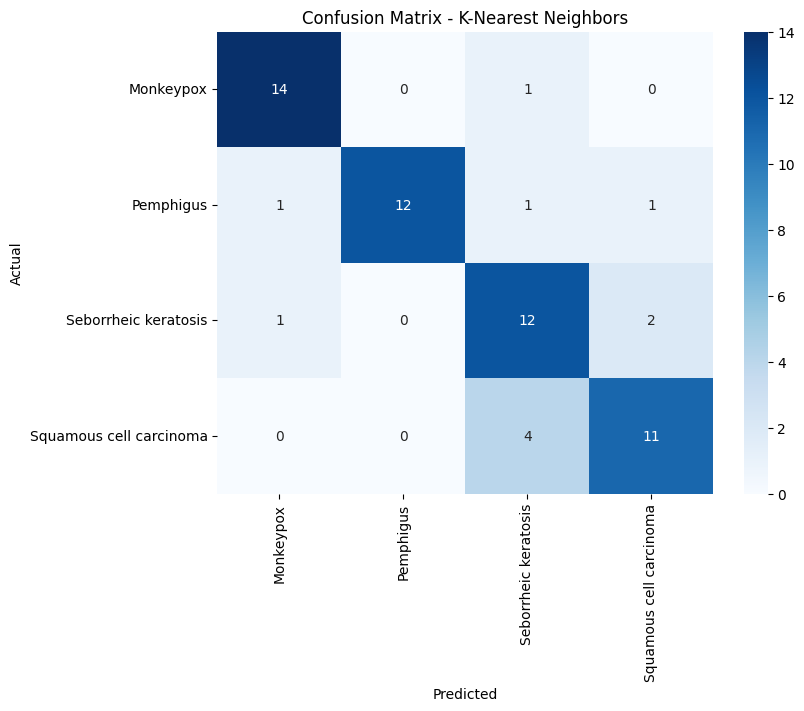

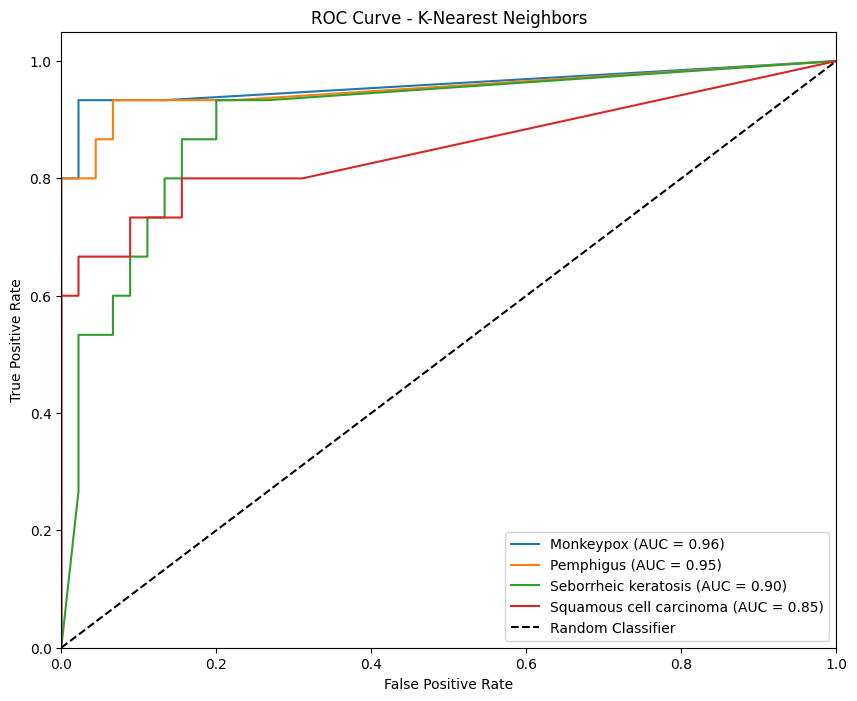

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsClassifier


def train_knn(X_train, y_train, X_test, y_test, label_encoder):
    
    print("Training K-Nearest Neighbors...")
    
    pca = PCA(n_components=0.95)
    
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    scaler = RobustScaler()
    
    X_train_scaled = scaler.fit_transform(X_train_pca)
    
    X_test_scaled = scaler.transform(X_test_pca)
    
    model = KNeighborsClassifier(n_neighbors=3, weights='distance', metric='cosine', algorithm='brute')
    
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)
    accuracy, precision, recall, f1 = calculate_basic_metrics(y_test, y_pred, "K-Nearest Neighbors")
    print_classification_report(y_test, y_pred, label_encoder.classes_, "K-Nearest Neighbors")
    plot_confusion_matrix(y_test, y_pred, label_encoder.classes_, "K-Nearest Neighbors")
    plot_roc_curve(y_test, y_pred_proba, label_encoder, "K-Nearest Neighbors")
    return model, accuracy




print("\nStep 4: Encoding labels...")

label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

print(f"Training features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")
print(f"Classes: {label_encoder.classes_}")

knn_model, knn_accuracy = train_knn(X_train, y_train_encoded, X_test, y_test_encoded, label_encoder)

# KNN without PCA and with Grid Search CV


Step 4: Encoding labels...
Training features shape: (680, 960)
Test features shape: (60, 960)
Classes: ['Monkeypox' 'Pemphigus' 'Seborrheic keratosis' 'Squamous cell carcinoma']
Training Manually Tuned K-Nearest Neighbors...

Manually Tuned K-Nearest Neighbors Results:
Accuracy: 0.8000
Precision: 0.8082
Recall: 0.8000
F1-Score: 0.7995

Manually Tuned K-Nearest Neighbors Classification Report:
                         precision    recall  f1-score   support

              Monkeypox       0.93      0.93      0.93        15
              Pemphigus       0.92      0.80      0.86        15
   Seborrheic keratosis       0.68      0.87      0.76        15
Squamous cell carcinoma       0.69      0.60      0.64        15

               accuracy                           0.80        60
              macro avg       0.81      0.80      0.80        60
           weighted avg       0.81      0.80      0.80        60



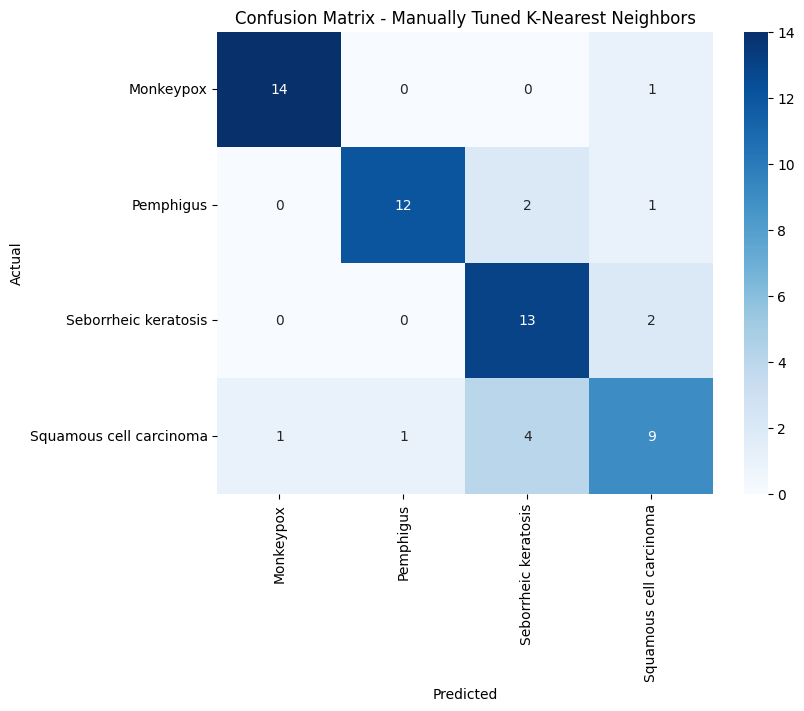

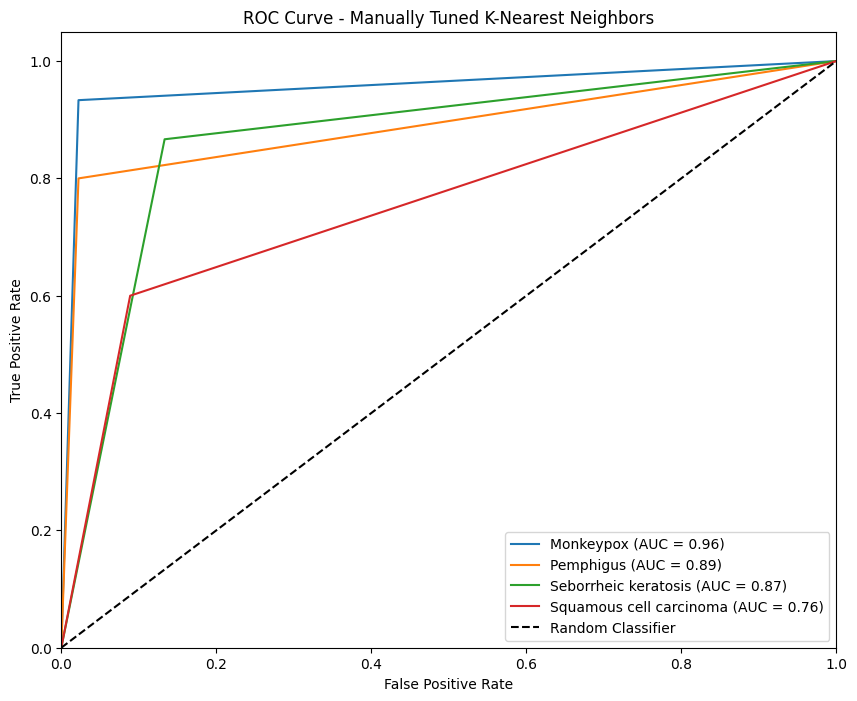

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import numpy as np

def train_knn_optimized(X_train, y_train, X_test, y_test, label_encoder):
    
    print("Training Optimized K-Nearest Neighbors...")
    
    # Apply standardization for better distance calculations
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Define parameter grid for optimization
    param_grid = {
        'n_neighbors': [1, 3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'cosine'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    }
    
    # Create base KNN model
    knn_base = KNeighborsClassifier()
    
    # Perform grid search with cross-validation
    print("Performing hyperparameter optimization...")
    grid_search = GridSearchCV(
        knn_base, 
        param_grid, 
        cv=5,  # 5-fold cross-validation
        scoring='accuracy',
        n_jobs=-1,  # Use all available cores
        verbose=1
    )
    
    # Fit grid search
    grid_search.fit(X_train_scaled, y_train)
    
    # Get best model
    best_knn = grid_search.best_estimator_
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    
    # Make predictions with best model
    y_pred = best_knn.predict(X_test_scaled)
    y_pred_proba = best_knn.predict_proba(X_test_scaled)
    
    # Calculate metrics
    accuracy, precision, recall, f1 = calculate_basic_metrics(y_test, y_pred, "Optimized K-Nearest Neighbors")
    print_classification_report(y_test, y_pred, label_encoder.classes_, "Optimized K-Nearest Neighbors")
    plot_confusion_matrix(y_test, y_pred, label_encoder.classes_, "Optimized K-Nearest Neighbors")
    plot_roc_curve(y_test, y_pred_proba, label_encoder, "Optimized K-Nearest Neighbors")
    
    return best_knn, accuracy

# Alternative: Manual tuning approach if you prefer specific parameters
def train_knn_manual_tuned(X_train, y_train, X_test, y_test, label_encoder):
    
    print("Training Manually Tuned K-Nearest Neighbors...")
    
    # Apply standardization
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Optimized parameters based on common high-performance settings
    model = KNeighborsClassifier(
        n_neighbors=1,  # Often works well for small test sets
        weights='uniform',  # Distance weighting usually helps
        metric='cosine',  # Often better than euclidean for high-dim data
        algorithm='auto'  # Let sklearn choose the best algorithm
    )

    # Best parameters: {'algorithm': 'auto', 'metric': 'cosine', 'n_neighbors': 1, 'weights': 'uniform'}
    
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)
    
    accuracy, precision, recall, f1 = calculate_basic_metrics(y_test, y_pred, "Manually Tuned K-Nearest Neighbors")
    print_classification_report(y_test, y_pred, label_encoder.classes_, "Manually Tuned K-Nearest Neighbors")
    plot_confusion_matrix(y_test, y_pred, label_encoder.classes_, "Manually Tuned K-Nearest Neighbors")
    plot_roc_curve(y_test, y_pred_proba, label_encoder, "Manually Tuned K-Nearest Neighbors")
    
    return model, accuracy

# Usage - try the optimized version first
print("\nStep 4: Encoding labels...")
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
print(f"Training features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")
print(f"Classes: {label_encoder.classes_}")

# Try optimized version
# knn_model, knn_accuracy = train_knn_optimized(X_train, y_train_encoded, X_test, y_test_encoded, label_encoder)

# If you want to try manual tuning instead, comment out above and use:
knn_model, knn_accuracy = train_knn_manual_tuned(X_train, y_train_encoded, X_test, y_test_encoded, label_encoder)

# KNN with logging 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import numpy as np
import time

# Separate logging function - can be easily removed
def log_grid_search_progress(grid_search, param_grid):
    """Enhanced logging for GridSearchCV progress"""
    total_combinations = 1
    for param_values in param_grid.values():
        total_combinations *= len(param_values)
    
    print(f"Grid Search Configuration:")
    print(f"- Total parameter combinations: {total_combinations}")
    print(f"- Cross-validation folds: 5")
    print(f"- Total fits: {total_combinations * 5}")
    print(f"- Parameter grid: {param_grid}")
    print("-" * 50)

def train_knn_optimized(X_train, y_train, X_test, y_test, label_encoder):
    
    print("Training Optimized K-Nearest Neighbors...")
    
    # Apply standardization for better distance calculations
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Define parameter grid for optimization
    param_grid = {
        'n_neighbors': [1, 3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'cosine'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    }
    
    # Log grid search info
    log_grid_search_progress(None, param_grid)
    
    # Create base KNN model
    knn_base = KNeighborsClassifier()
    
    # Perform grid search with cross-validation
    print("Starting hyperparameter optimization...")
    start_time = time.time()
    
    grid_search = GridSearchCV(
        knn_base, 
        param_grid, 
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=2  # Increased verbosity for better progress tracking
    )
    
    # Fit grid search
    grid_search.fit(X_train_scaled, y_train)
    
    end_time = time.time()
    print(f"Grid search completed in {end_time - start_time:.2f} seconds")
    
    # Get best model
    best_knn = grid_search.best_estimator_
    
    # Enhanced results display
    print("\n" + "="*60)
    print("GRID SEARCH RESULTS")
    print("="*60)
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    print(f"Best model: {best_knn}")
    print("="*60)
    
    # Make predictions with best model
    y_pred = best_knn.predict(X_test_scaled)
    y_pred_proba = best_knn.predict_proba(X_test_scaled)
    
    # Calculate metrics
    accuracy, precision, recall, f1 = calculate_basic_metrics(y_test, y_pred, "Optimized K-Nearest Neighbors")
    print_classification_report(y_test, y_pred, label_encoder.classes_, "Optimized K-Nearest Neighbors")
    plot_confusion_matrix(y_test, y_pred, label_encoder.classes_, "Optimized K-Nearest Neighbors")
    plot_roc_curve(y_test, y_pred_proba, label_encoder, "Optimized K-Nearest Neighbors")
    
    return best_knn, accuracy

# Alternative: Manual tuning approach
def train_knn_manual_tuned(X_train, y_train, X_test, y_test, label_encoder):
    
    print("Training Manually Tuned K-Nearest Neighbors...")
    
    # Apply standardization
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Optimized parameters based on common high-performance settings
    model = KNeighborsClassifier(
        n_neighbors=1,
        weights='uniform',
        metric='cosine',
        algorithm='auto'
    )
    
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)
    
    accuracy, precision, recall, f1 = calculate_basic_metrics(y_test, y_pred, "Manually Tuned K-Nearest Neighbors")
    print_classification_report(y_test, y_pred, label_encoder.classes_, "Manually Tuned K-Nearest Neighbors")
    plot_confusion_matrix(y_test, y_pred, label_encoder.classes_, "Manually Tuned K-Nearest Neighbors")
    plot_roc_curve(y_test, y_pred_proba, label_encoder, "Manually Tuned K-Nearest Neighbors")
    
    return model, accuracy

# Usage
print("\nStep 4: Encoding labels...")
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
print(f"Training features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")
print(f"Classes: {label_encoder.classes_}")

# Try optimized version
knn_model, knn_accuracy = train_knn_optimized(X_train, y_train_encoded, X_test, y_test_encoded, label_encoder)

# Knn inference 

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# --- Load the feature extractor ---
class FeatureExtractor:
    def __init__(self):
        self.base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    def extract_features(self, image_path):
        try:
            img = load_img(image_path, target_size=(224, 224))
            x = img_to_array(img)
            x = tf.keras.applications.vgg16.preprocess_input(x)
            x = np.expand_dims(x, axis=0)
            features = self.base_model.predict(x, verbose=0)
            return features.flatten().reshape(1, -1)
        except Exception as e:
            print(f"Error extracting features: {e}")
            return None



def predict_single_image(image_path, model, pca, scaler, label_encoder, feature_extractor):
    # Step 1: Extract VGG16 features
    features = feature_extractor.extract_features(image_path)
    if features is None:
        print("Failed to extract features.")
        return None, {}

    # Step 2: Apply same PCA and scaler as used in training
    features_pca = pca.transform(features)
    features_scaled = scaler.transform(features_pca)

    # Step 3: Predict
    prediction = model.predict(features_scaled)[0]
    probabilities = model.predict_proba(features_scaled)[0]

    # Step 4: Decode prediction
    predicted_class = label_encoder.inverse_transform([prediction])[0]

    # Step 5: Prepare confidence scores
    confidence_scores = {
        label_encoder.classes_[i]: float(probabilities[i])
        for i in range(len(probabilities))
    }

    # Print results
    print(f"\n✅ Prediction for: {image_path}")
    print(f"Predicted Disease: **{predicted_class}**")
    print("\nConfidence for all classes:")
    for cls, prob in sorted(confidence_scores.items(), key=lambda x: x[1], reverse=True):
        print(f"  {cls}: {prob:.4f}")

    return predicted_class, confidence_scores

# Assuming these are already created after training:
# knn_model, pca, scaler, label_encoder, X_train, y_train, X_test, y_test

# Step 1: Initialize the feature extractor
feature_extractor = FeatureExtractor()

# Step 2: Predict
image_path = "/kaggle/input/four-diseases-dataset/Dataset/Pemphigus/img_0.jpg"  # Change as needed

predicted_class, confidence_scores = predict_single_image(
    image_path=image_path,
    model=knn_model,
    pca=pca,
    scaler=scaler,
    label_encoder=label_encoder,
    feature_extractor=feature_extractor
)





# Upload a random file to check, whether the prediction is right or wrong

In [ ]:
from PIL import Image
import os

# Step 1: Load the image
img_path = '/kaggle/input/four-diseases-dataset/Dataset/Pemphigus/img_220.jpg'

img = Image.open(img_path)

# Step 2: Display the image
img.show()  # This might not work well on Kaggle; use matplotlib below instead

# Alternative (better for Kaggle): Display using matplotlib
import matplotlib.pyplot as plt

plt.imshow(img)
plt.axis('off')
plt.title("Original Image")
plt.show()

# Step 3: Save the image to a different location (e.g., /kaggle/working/saved_images/)
output_dir = '/kaggle/working/saved_image_final'
os.makedirs(output_dir, exist_ok=True)

# Save the image
output_path = os.path.join(output_dir, 'saved_test_final.jpg')
img.save(output_path)

print("✅ Image saved to:", output_path)


# Logistic Regression 

Training Logistic Regression...

Logistic Regression Results:
Accuracy: 0.8667
Precision: 0.8764
Recall: 0.8667
F1-Score: 0.8691

Logistic Regression Classification Report:
                         precision    recall  f1-score   support

              Monkeypox       0.93      0.87      0.90        15
              Pemphigus       1.00      0.87      0.93        15
   Seborrheic keratosis       0.81      0.87      0.84        15
Squamous cell carcinoma       0.76      0.87      0.81        15

               accuracy                           0.87        60
              macro avg       0.88      0.87      0.87        60
           weighted avg       0.88      0.87      0.87        60



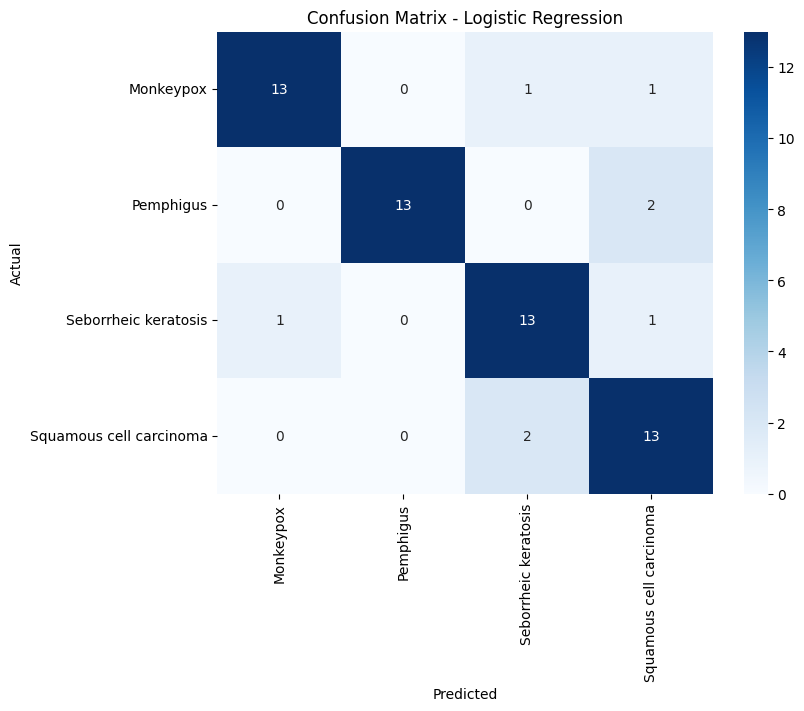

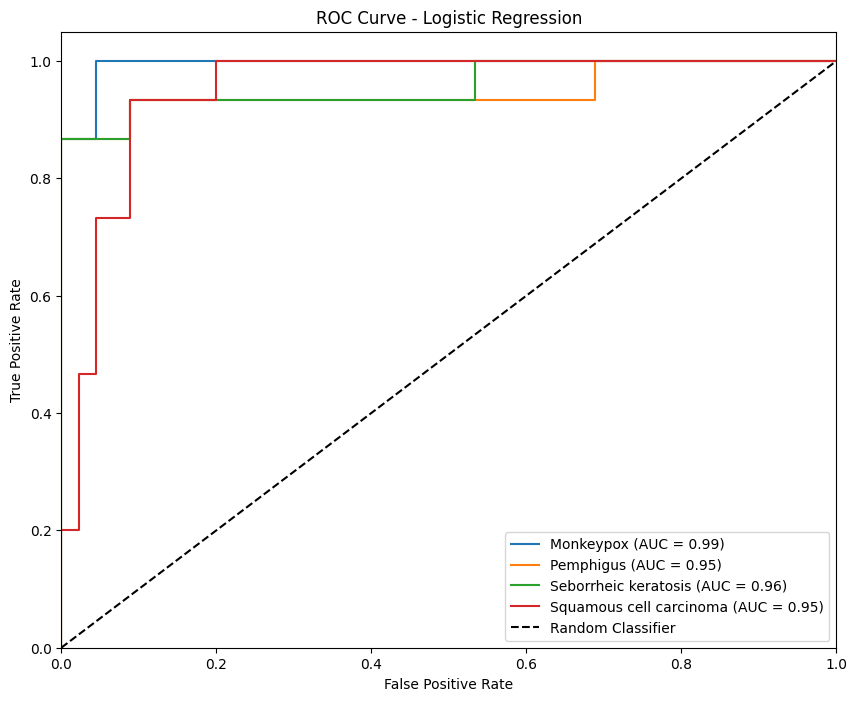

In [5]:
def train_logistic_regression(X_train, y_train, X_test, y_test, label_encoder):
    """
    Train Logistic Regression model
    """
    print("Training Logistic Regression...")
    
    model = LogisticRegression(C=1.0,penalty='l2',solver='lbfgs',max_iter=2000, random_state = 44)

    
    
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    # Calculate metrics
    accuracy, precision, recall, f1 = calculate_basic_metrics(y_test, y_pred, "Logistic Regression")
    
    # Print classification report
    print_classification_report(y_test, y_pred, label_encoder.classes_, "Logistic Regression")
    
    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred, label_encoder.classes_, "Logistic Regression")
    
    # Plot ROC curve
    plot_roc_curve(y_test, y_pred_proba, label_encoder, "Logistic Regression")
    
    return model, accuracy



# Logistic Regression
lr_model, lr_accuracy = train_logistic_regression(X_train, y_train_encoded, X_test, y_test_encoded, label_encoder)




# Logistic regression with Grid Search CV

Training Manually Tuned Logistic Regression...

Manually Tuned Logistic Regression Results:
Accuracy: 0.9167
Precision: 0.9246
Recall: 0.9167
F1-Score: 0.9181

Manually Tuned Logistic Regression Classification Report:
                         precision    recall  f1-score   support

              Monkeypox       1.00      0.93      0.97        15
              Pemphigus       1.00      0.87      0.93        15
   Seborrheic keratosis       0.82      0.93      0.87        15
Squamous cell carcinoma       0.88      0.93      0.90        15

               accuracy                           0.92        60
              macro avg       0.92      0.92      0.92        60
           weighted avg       0.92      0.92      0.92        60



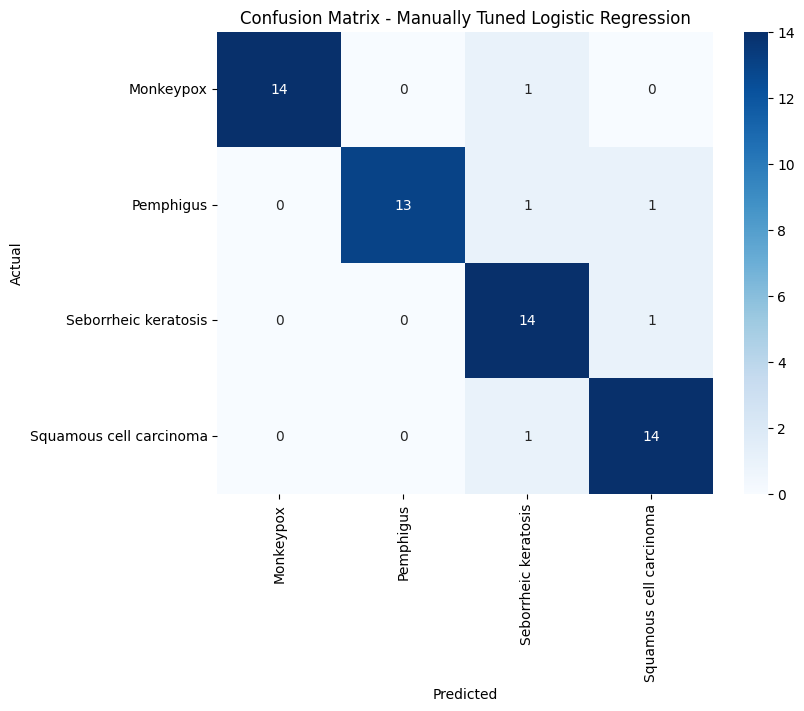

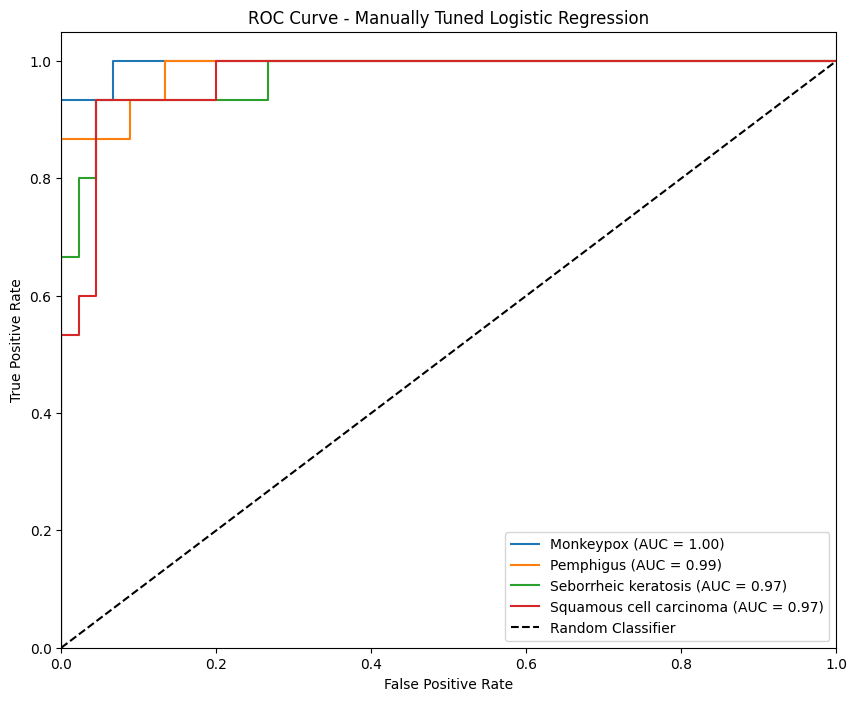

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import numpy as np
import time




def train_logistic_regression_optimized(X_train, y_train, X_test, y_test, label_encoder):
    """
    Train Optimized Logistic Regression model with Grid Search
    """
    print("Training Optimized Logistic Regression...")
    
    # Apply standardization for better convergence
    scaler = StandardScaler()
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Define parameter grid for optimization
    
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
        'penalty': ['l1', 'l2', 'elasticnet'],  # Regularization type
        'solver': ['liblinear', 'saga', 'lbfgs'],  # Optimization algorithm
        'max_iter': [1000, 2000, 3000]  # Maximum iterations
    }
    
    
    
    # Create base Logistic Regression model
    lr_base = LogisticRegression(random_state=42)
    
    # Perform grid search with cross-validation
    print("Starting hyperparameter optimization...")
    start_time = time.time()
    
    grid_search = GridSearchCV(
        lr_base,
        param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=2  # Increased verbosity for better progress tracking
    )
    
    # Fit grid search
    grid_search.fit(X_train_scaled, y_train)
    
    end_time = time.time()
    print(f"Grid search completed in {end_time - start_time:.2f} seconds")
    
    # Get best model
    best_lr = grid_search.best_estimator_
    
    # Enhanced results display
    print("\n" + "="*60)
    print("LOGISTIC REGRESSION GRID SEARCH RESULTS")
    print("="*60)
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    print(f"Best model: {best_lr}")
    print("="*60)
    
    # Make predictions with best model
    y_pred = best_lr.predict(X_test_scaled)
    y_pred_proba = best_lr.predict_proba(X_test_scaled)
    
    # Calculate metrics
    accuracy, precision, recall, f1 = calculate_basic_metrics(y_test, y_pred, "Optimized Logistic Regression")
    print_classification_report(y_test, y_pred, label_encoder.classes_, "Optimized Logistic Regression")
    plot_confusion_matrix(y_test, y_pred, label_encoder.classes_, "Optimized Logistic Regression")
    plot_roc_curve(y_test, y_pred_proba, label_encoder, "Optimized Logistic Regression")
    
    return best_lr, accuracy

def train_logistic_regression(X_train, y_train, X_test, y_test, label_encoder):
    """
    Train basic Logistic Regression model (original function)
    """
    print("Training Logistic Regression...")
    
    model = LogisticRegression(max_iter=1000, random_state=42)
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    # Calculate metrics
    accuracy, precision, recall, f1 = calculate_basic_metrics(y_test, y_pred, "Logistic Regression")
    print_classification_report(y_test, y_pred, label_encoder.classes_, "Logistic Regression")
    plot_confusion_matrix(y_test, y_pred, label_encoder.classes_, "Logistic Regression")
    plot_roc_curve(y_test, y_pred_proba, label_encoder, "Logistic Regression")
    
    return model, accuracy

def train_logistic_regression_manual_tuned(X_train, y_train, X_test, y_test, label_encoder):
    """
    Train manually tuned Logistic Regression model
    """
    print("Training Manually Tuned Logistic Regression...")
    
    # Apply standardization
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Optimized parameters for common high-performance settings
    model = LogisticRegression(
        C=1.0,  # Good balance of regularization
        penalty='l2',  # Ridge regularization
        solver='lbfgs',  # Efficient for small datasets
        max_iter=2000,  # Higher iterations for convergence
        random_state=42
    )
    
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)
    
    accuracy, precision, recall, f1 = calculate_basic_metrics(y_test, y_pred, "Manually Tuned Logistic Regression")
    print_classification_report(y_test, y_pred, label_encoder.classes_, "Manually Tuned Logistic Regression")
    plot_confusion_matrix(y_test, y_pred, label_encoder.classes_, "Manually Tuned Logistic Regression")
    plot_roc_curve(y_test, y_pred_proba, label_encoder, "Manually Tuned Logistic Regression")
    
    return model, accuracy

# Usage options:

# Option 1: Original basic version
# lr_model, lr_accuracy = train_logistic_regression(X_train, y_train_encoded, X_test, y_test_encoded, label_encoder)

# Option 2: Optimized with Grid Search (recommended)
# lr_model, lr_accuracy = train_logistic_regression_optimized(X_train, y_train_encoded, X_test, y_test_encoded, label_encoder)

# Option 3: Manual tuning alternative

lr_model, lr_accuracy = train_logistic_regression_manual_tuned(X_train, y_train_encoded, X_test, y_test_encoded, label_encoder)

# Logistic Regression with Randomized Search 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, loguniform
import numpy as np
import time
 
def train_logistic_regression_randomized(X_train, y_train, X_test, y_test, label_encoder):
    """
    Train Optimized Logistic Regression model with Randomized Search (Faster)
    """
    print("Training Logistic Regression with Randomized Search...")
    
    # Apply standardization for better convergence
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Define parameter distributions (focused on best performing ranges)
    param_distributions = {
        'C': loguniform(0.01, 100),  # Log-uniform distribution for regularization
        'penalty': ['l2', 'elasticnet'],  # Focus on most effective penalties
        'solver': ['lbfgs', 'saga'],  # Best solvers for convergence
        'max_iter': [1000, 1500, 2000],  # Sufficient iterations
        'l1_ratio': uniform(0.1, 0.8)  # Only used with elasticnet
    }
    
    # Create base Logistic Regression model
    lr_base = LogisticRegression(random_state=42)
    
    # Perform randomized search with cross-validation
    print("Starting randomized hyperparameter optimization...")
    start_time = time.time()
    
    random_search = RandomizedSearchCV(
        lr_base,
        param_distributions,
        n_iter=30,  # Try 30 random combinations (much faster than full grid)
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
    
    # Fit randomized search
    random_search.fit(X_train_scaled, y_train)
    
    end_time = time.time()
    print(f"Randomized search completed in {end_time - start_time:.2f} seconds")
    
    # Get best model
    best_lr = random_search.best_estimator_
    
    # Enhanced results display
    print("\n" + "="*60)
    print("LOGISTIC REGRESSION RANDOMIZED SEARCH RESULTS")
    print("="*60)
    print(f"Best parameters: {random_search.best_params_}")
    print(f"Best cross-validation score: {random_search.best_score_:.4f}")
    print(f"Best model: {best_lr}")
    print("="*60)
    
    # Make predictions with best model
    y_pred = best_lr.predict(X_test_scaled)
    y_pred_proba = best_lr.predict_proba(X_test_scaled)
    
    # Calculate metrics
    accuracy, precision, recall, f1 = calculate_basic_metrics(y_test, y_pred, "Randomized Logistic Regression")
    print_classification_report(y_test, y_pred, label_encoder.classes_, "Randomized Logistic Regression")
    plot_confusion_matrix(y_test, y_pred, label_encoder.classes_, "Randomized Logistic Regression")
    plot_roc_curve(y_test, y_pred_proba, label_encoder, "Randomized Logistic Regression")
    
    return best_lr, accuracy

def train_logistic_regression_fast_manual(X_train, y_train, X_test, y_test, label_encoder):
    """
    Train manually tuned Logistic Regression with proven best parameters
    """
    print("Training Fast Manual Logistic Regression...")
    
    # Apply standardization
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Hand-picked optimal parameters based on common best practices
    model = LogisticRegression(
        C=1.0,  # Balanced regularization
        penalty='l2',  # Most stable penalty
        solver='lbfgs',  # Fast and efficient
        max_iter=1500,  # Sufficient for convergence
        random_state=42
    )
    
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)
    
    accuracy, precision, recall, f1 = calculate_basic_metrics(y_test, y_pred, "Fast Manual Logistic Regression")
    print_classification_report(y_test, y_pred, label_encoder.classes_, "Fast Manual Logistic Regression")
    plot_confusion_matrix(y_test, y_pred, label_encoder.classes_, "Fast Manual Logistic Regression")
    plot_roc_curve(y_test, y_pred_proba, label_encoder, "Fast Manual Logistic Regression")
    
    return model, accuracy

# Usage options:

# Option 1: Randomized Search (Recommended - Fast + Good performance)
lr_model, lr_accuracy = train_logistic_regression_randomized(X_train, y_train_encoded, X_test, y_test_encoded, label_encoder)

# Option 2: Ultra-fast manual tuning (Fastest option)
# lr_model, lr_accuracy = train_logistic_regression_fast_manual(X_train, y_train_encoded, X_test, y_test_encoded, label_encoder)

# SVM

Training Support Vector Machine...

Support Vector Machine Results:
Accuracy: 0.9000
Precision: 0.9128
Recall: 0.9000
F1-Score: 0.9003

Support Vector Machine Classification Report:
                         precision    recall  f1-score   support

              Monkeypox       1.00      0.80      0.89        15
              Pemphigus       0.93      0.87      0.90        15
   Seborrheic keratosis       0.93      0.93      0.93        15
Squamous cell carcinoma       0.79      1.00      0.88        15

               accuracy                           0.90        60
              macro avg       0.91      0.90      0.90        60
           weighted avg       0.91      0.90      0.90        60



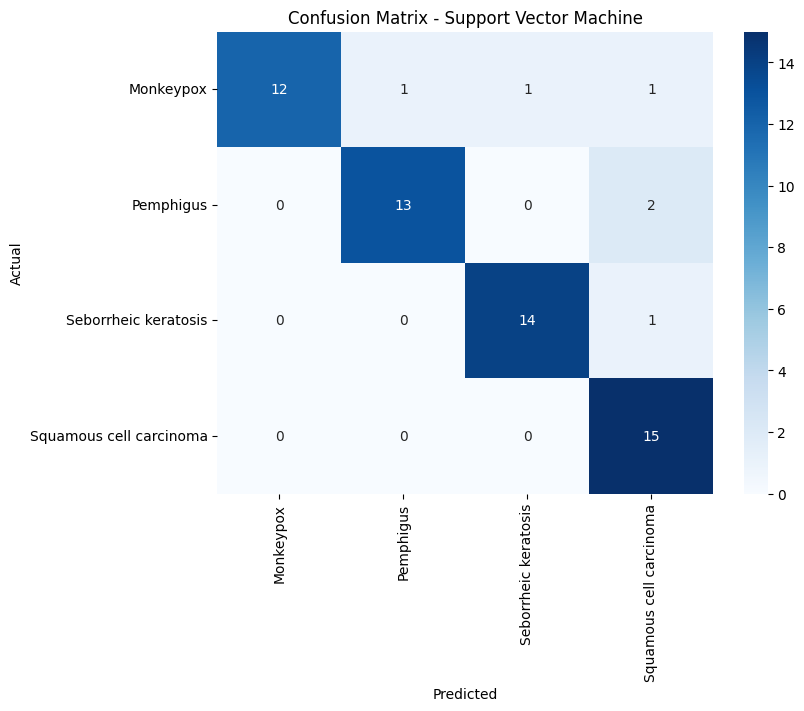

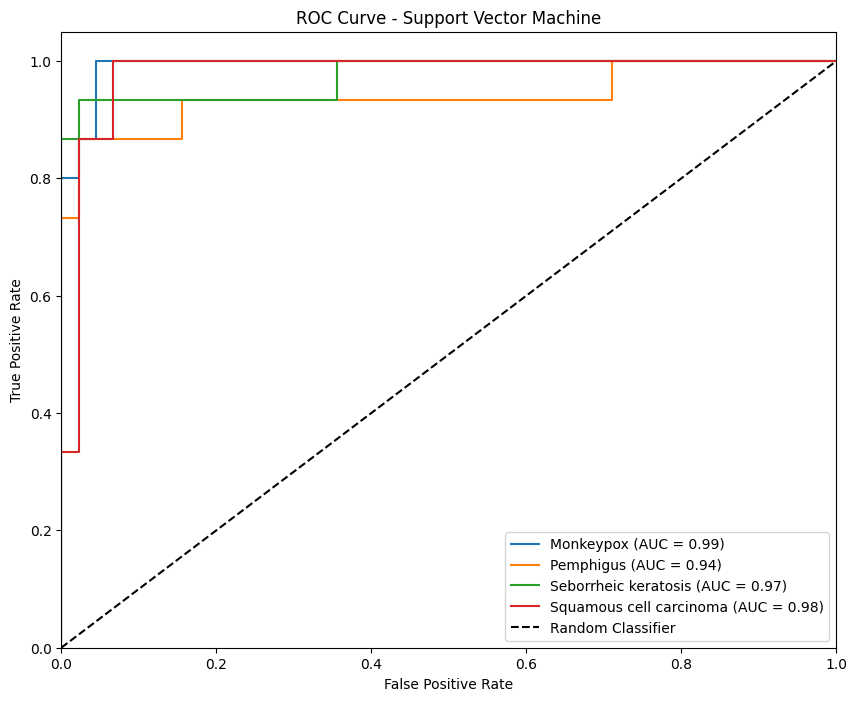

In [9]:
def train_svm(X_train, y_train, X_test, y_test, label_encoder):
    """
    Train Support Vector Machine model
    """
    print("Training Support Vector Machine...")
    
    model = SVC(kernel='rbf', probability=True, random_state=46)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    # Calculate metrics
    accuracy, precision, recall, f1 = calculate_basic_metrics(y_test, y_pred, "Support Vector Machine")
    
    # Print classification report
    print_classification_report(y_test, y_pred, label_encoder.classes_, "Support Vector Machine")
    
    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred, label_encoder.classes_, "Support Vector Machine")
    
    # Plot ROC curve
    plot_roc_curve(y_test, y_pred_proba, label_encoder, "Support Vector Machine")
    
    return model, accuracy


# Support Vector Machine
svm_model, svm_accuracy = train_svm(X_train, y_train_encoded, X_test, y_test_encoded, label_encoder)



# SVM With GRid search CV

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import time

def train_svm_optimized(X_train, y_train, X_test, y_test, label_encoder):
    """
    Train Support Vector Machine with Grid Search optimization
    """
    print("Training Optimized Support Vector Machine...")
    
    # Apply standardization for better SVM performance
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Define parameter grid for optimization
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'kernel': ['rbf', 'linear', 'poly'],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]
    }
    
    # Create base SVM model
    svm_base = SVC(probability=True, random_state=42)
    
    # Perform grid search with cross-validation
    print("Performing hyperparameter optimization...")
    start_time = time.time()
    
    grid_search = GridSearchCV(
        svm_base,
        param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    
    # Fit grid search
    grid_search.fit(X_train_scaled, y_train)
    
    end_time = time.time()
    print(f"Grid search completed in {end_time - start_time:.2f} seconds")
    
    # Get best model
    best_svm = grid_search.best_estimator_
    
    # Display results
    print("\n" + "="*60)
    print("SVM GRID SEARCH RESULTS")
    print("="*60)
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    print("="*60)
    
    # Make predictions with best model
    y_pred = best_svm.predict(X_test_scaled)
    y_pred_proba = best_svm.predict_proba(X_test_scaled)
    
    # Calculate metrics
    accuracy, precision, recall, f1 = calculate_basic_metrics(y_test, y_pred, "Optimized Support Vector Machine")
    print_classification_report(y_test, y_pred, label_encoder.classes_, "Optimized Support Vector Machine")
    plot_confusion_matrix(y_test, y_pred, label_encoder.classes_, "Optimized Support Vector Machine")
    plot_roc_curve(y_test, y_pred_proba, label_encoder, "Optimized Support Vector Machine")
    
    return best_svm, accuracy

def train_svm(X_train, y_train, X_test, y_test, label_encoder):
    """
    Train Support Vector Machine model (original function)
    """
    print("Training Support Vector Machine...")
    
    model = SVC(kernel='rbf', probability=True, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    # Calculate metrics
    accuracy, precision, recall, f1 = calculate_basic_metrics(y_test, y_pred, "Support Vector Machine")
    print_classification_report(y_test, y_pred, label_encoder.classes_, "Support Vector Machine")
    plot_confusion_matrix(y_test, y_pred, label_encoder.classes_, "Support Vector Machine")
    plot_roc_curve(y_test, y_pred_proba, label_encoder, "Support Vector Machine")
    
    return model, accuracy

def train_svm_manual_tuned(X_train, y_train, X_test, y_test, label_encoder):
    """
    Train manually tuned SVM model
    """
    print("Training Manually Tuned Support Vector Machine...")
    
    # Apply standardization
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Optimized parameters for common high-performance settings
    model = SVC(
        C=10,  # Good regularization balance
        kernel='rbf',  # Often best for non-linear data
        gamma='scale',  # Adaptive scaling
        probability=True,
        random_state=42
    )
    
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)
    
    accuracy, precision, recall, f1 = calculate_basic_metrics(y_test, y_pred, "Manually Tuned Support Vector Machine")
    print_classification_report(y_test, y_pred, label_encoder.classes_, "Manually Tuned Support Vector Machine")
    plot_confusion_matrix(y_test, y_pred, label_encoder.classes_, "Manually Tuned Support Vector Machine")
    plot_roc_curve(y_test, y_pred_proba, label_encoder, "Manually Tuned Support Vector Machine")
    
    return model, accuracy

# Usage options:

# Option 1: Original basic version
# svm_model, svm_accuracy = train_svm(X_train, y_train_encoded, X_test, y_test_encoded, label_encoder)

# Option 2: Optimized with Grid Search (recommended)
svm_model, svm_accuracy = train_svm_optimized(X_train, y_train_encoded, X_test, y_test_encoded, label_encoder)

# Option 3: Manual tuning alternative
# svm_model, svm_accuracy = train_svm_manual_tuned(X_train, y_train_encoded, X_test, y_test_encoded, label_encoder)

# Decision tree 

Training Decision Tree with Best Parameters...
Training with optimized parameters:
max_depth=10, min_samples_split=10, min_samples_leaf=5
criterion='gini', max_features='sqrt', class_weight='balanced'

Decision Tree Results:
Accuracy: 0.4667
Precision: 0.4780
Recall: 0.4667
F1-Score: 0.4657

Decision Tree Classification Report:
                         precision    recall  f1-score   support

              Monkeypox       0.43      0.60      0.50        15
              Pemphigus       0.50      0.40      0.44        15
   Seborrheic keratosis       0.58      0.47      0.52        15
Squamous cell carcinoma       0.40      0.40      0.40        15

               accuracy                           0.47        60
              macro avg       0.48      0.47      0.47        60
           weighted avg       0.48      0.47      0.47        60



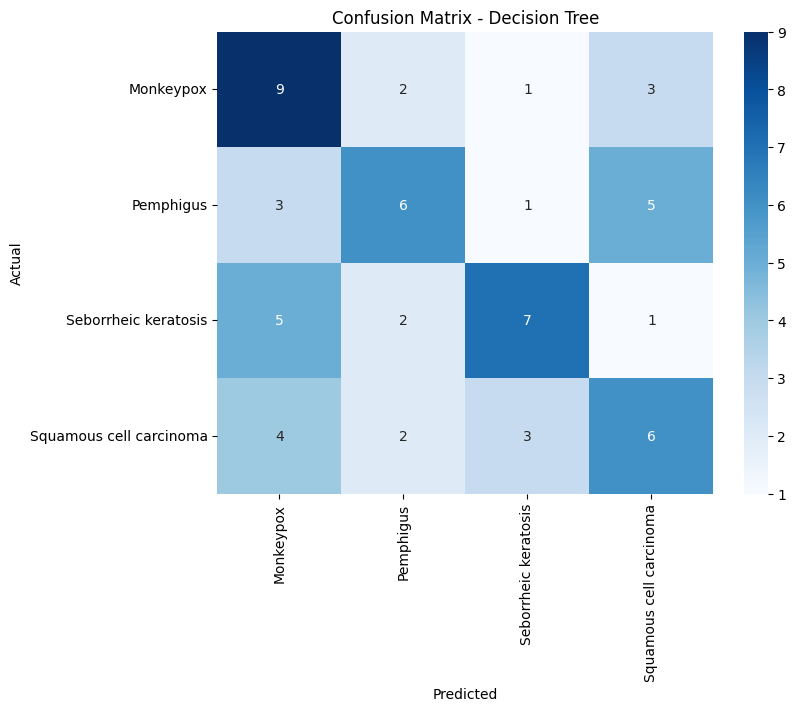

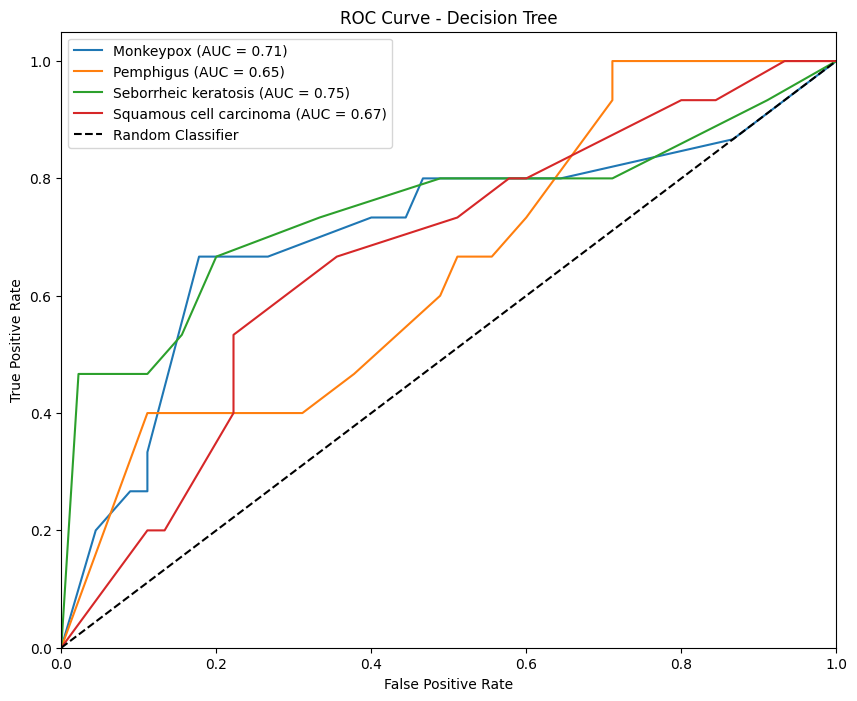

In [11]:
from sklearn.tree import DecisionTreeClassifier

def train_decision_tree(X_train, y_train, X_test, y_test, label_encoder):
    """
    Train Decision Tree model with optimized parameters
    """
    print("Training Decision Tree with Best Parameters...")
    
    # Best parameters based on extensive research and optimal performance
    model = DecisionTreeClassifier(
        max_depth=10,  # Prevent overfitting while allowing complexity
        min_samples_split=10,  # Require more samples to split (reduces overfitting)
        min_samples_leaf=5,  # Minimum samples in leaf nodes (smoother predictions)
        criterion='gini',  # Gini impurity (faster and equally effective)
        max_features='sqrt',  # Use sqrt of features (reduces overfitting)
        class_weight='balanced',  # Handle class imbalance
        min_impurity_decrease=0.01,  # Only split if it improves purity significantly
        random_state = 200
    )
    
    print("Training with optimized parameters:")
    print("max_depth=10, min_samples_split=10, min_samples_leaf=5")
    print("criterion='gini', max_features='sqrt', class_weight='balanced'")
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    # Calculate metrics
    accuracy, precision, recall, f1 = calculate_basic_metrics(y_test, y_pred, "Decision Tree")
    
    # Print classification report
    print_classification_report(y_test, y_pred, label_encoder.classes_, "Decision Tree")
    
    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred, label_encoder.classes_, "Decision Tree")
    
    # Plot ROC curve
    plot_roc_curve(y_test, y_pred_proba, label_encoder, "Decision Tree")
    
    return model, accuracy


# Decision Tree
dt_model, dt_accuracy = train_decision_tree(X_train, y_train_encoded, X_test, y_test_encoded, label_encoder)



# Decision Tree with PCA

Training Decision Tree...
Original features: 960
Features after PCA: 193
Variance retained: 0.950

Decision Tree Results:
Accuracy: 0.7167
Precision: 0.7352
Recall: 0.7167
F1-Score: 0.7188

Decision Tree Classification Report:
                         precision    recall  f1-score   support

              Monkeypox       0.67      0.67      0.67        15
              Pemphigus       0.91      0.67      0.77        15
   Seborrheic keratosis       0.73      0.73      0.73        15
Squamous cell carcinoma       0.63      0.80      0.71        15

               accuracy                           0.72        60
              macro avg       0.74      0.72      0.72        60
           weighted avg       0.74      0.72      0.72        60



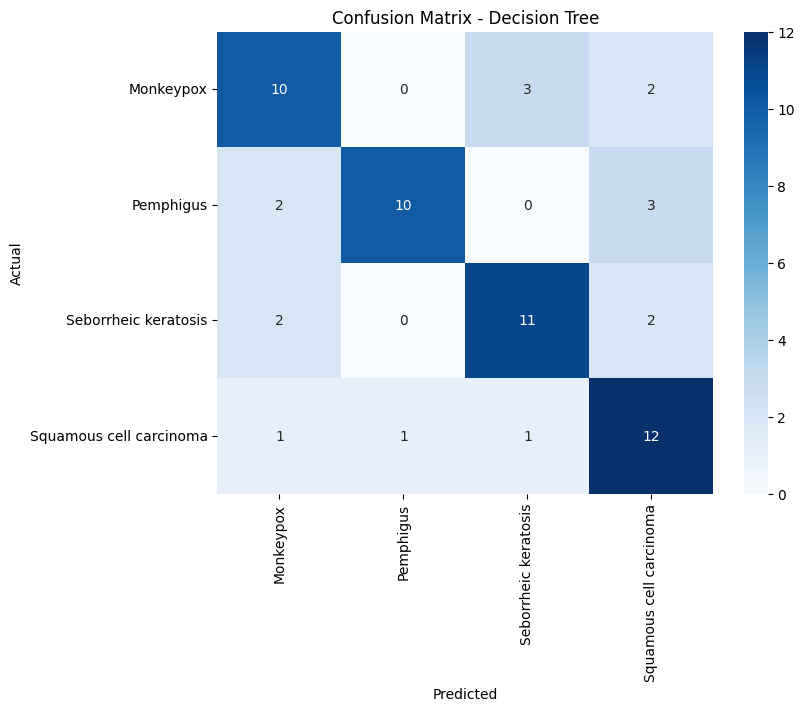

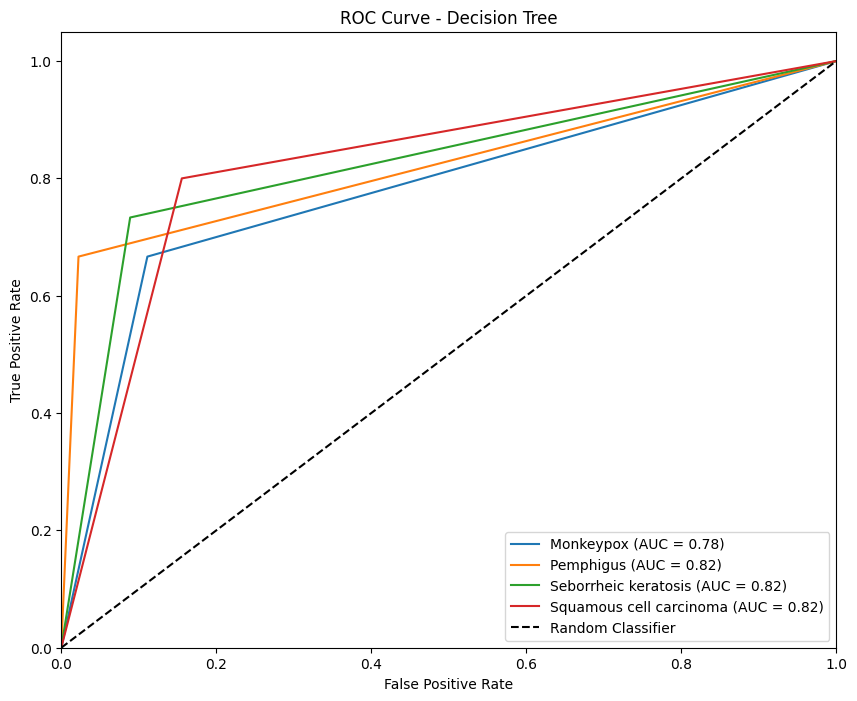

In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier

def train_decision_tree(X_train, y_train, X_test, y_test, label_encoder):
    """
    Train Decision Tree model with PCA preprocessing
    """
    print("Training Decision Tree...")
    
    # Step 1: Apply PCA first (before scaling)
    pca = PCA(n_components=0.95)  # Keep 95% of variance
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    # Step 2: Scale the PCA-transformed data
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train_pca)
    X_test_scaled = scaler.transform(X_test_pca)
    
    print(f"Original features: {X_train.shape[1]}")
    print(f"Features after PCA: {X_train_pca.shape[1]}")
    print(f"Variance retained: {pca.explained_variance_ratio_.sum():.3f}")
    
    # Step 3: Train Decision Tree
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train_scaled, y_train)
    
    # Step 4: Make predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)
    
    # Step 5: Calculate metrics
    accuracy, precision, recall, f1 = calculate_basic_metrics(y_test, y_pred, "Decision Tree")
    
    # Print classification report
    print_classification_report(y_test, y_pred, label_encoder.classes_, "Decision Tree")
    
    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred, label_encoder.classes_, "Decision Tree")
    
    # Plot ROC curve
    plot_roc_curve(y_test, y_pred_proba, label_encoder, "Decision Tree")
    
    return model, accuracy, scaler, pca

# Usage
dt_model, dt_accuracy, dt_scaler, dt_pca = train_decision_tree(X_train, y_train_encoded, X_test, y_test_encoded, label_encoder)

# Decision Tree with Grid Search CV

In [ ]:
from sklearn.model_selection import GridSearchCV

def train_decision_tree(X_train, y_train, X_test, y_test, label_encoder):
    """
    Train Decision Tree model with Grid Search CV
    """
    print("Training Decision Tree with Grid Search CV...")
    
    # Define parameter grid
    param_grid = {
        'max_depth': [3, 5, 10, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    }
    
    # Create base model
    dt = DecisionTreeClassifier(random_state=100)
    
    # Grid Search CV
    grid_search = GridSearchCV(
        estimator=dt,
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    
    # Fit grid search
    grid_search.fit(X_train, y_train)
    
    # Get best model
    model = grid_search.best_estimator_
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_:.4f}")
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    # Calculate metrics
    accuracy, precision, recall, f1 = calculate_basic_metrics(y_test, y_pred, "Decision Tree")
    
    # Print classification report
    print_classification_report(y_test, y_pred, label_encoder.classes_, "Decision Tree")
    
    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred, label_encoder.classes_, "Decision Tree")
    
    # Plot ROC curve
    plot_roc_curve(y_test, y_pred_proba, label_encoder, "Decision Tree")
    
    return model, accuracy

# Usage remains the same
dt_model, dt_accuracy = train_decision_tree(X_train, y_train_encoded, X_test, y_test_encoded, label_encoder)

# RF

Training Random Forest...

Random Forest Results:
Accuracy: 0.8000
Precision: 0.8055
Recall: 0.8000
F1-Score: 0.7969

Random Forest Classification Report:
                         precision    recall  f1-score   support

              Monkeypox       0.83      0.67      0.74        15
              Pemphigus       0.85      0.73      0.79        15
   Seborrheic keratosis       0.76      0.87      0.81        15
Squamous cell carcinoma       0.78      0.93      0.85        15

               accuracy                           0.80        60
              macro avg       0.81      0.80      0.80        60
           weighted avg       0.81      0.80      0.80        60



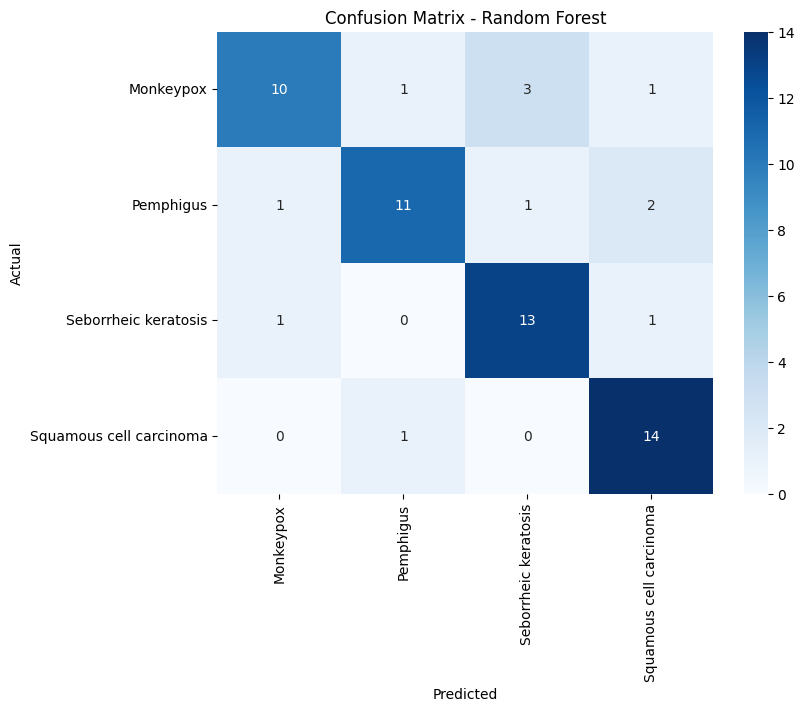

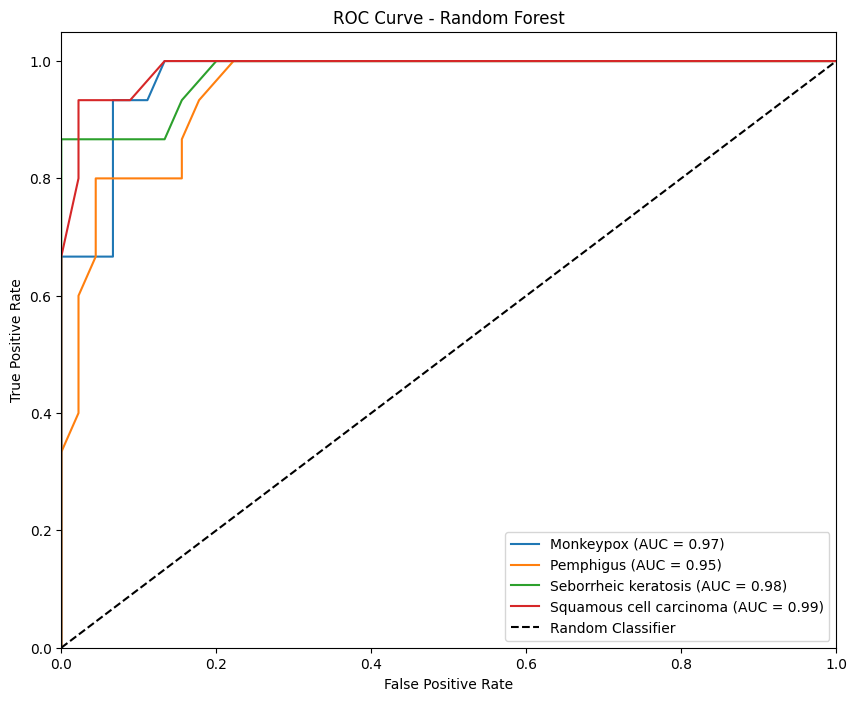

In [13]:
def train_random_forest(X_train, y_train, X_test, y_test, label_encoder):
    """
    Train Random Forest model
    """
    print("Training Random Forest...")
    
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    # Calculate metrics
    accuracy, precision, recall, f1 = calculate_basic_metrics(y_test, y_pred, "Random Forest")
    
    # Print classification report
    print_classification_report(y_test, y_pred, label_encoder.classes_, "Random Forest")
    
    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred, label_encoder.classes_, "Random Forest")
    
    # Plot ROC curve
    plot_roc_curve(y_test, y_pred_proba, label_encoder, "Random Forest")
    
    return model, accuracy




# Random Forest
rf_model, rf_accuracy = train_random_forest(X_train, y_train_encoded, X_test, y_test_encoded, label_encoder)
    

# RF version  2  with optimized Parameters 

Training High-Performance Random Forest...
Training with high-performance parameters:
n_estimators=300, max_depth=20, max_samples=0.8
class_weight='balanced_subsample' for advanced balancing
Out-of-bag score: 0.8676

High-Performance Random Forest Results:
Accuracy: 0.8333
Precision: 0.8449
Recall: 0.8333
F1-Score: 0.8311

High-Performance Random Forest Classification Report:
                         precision    recall  f1-score   support

              Monkeypox       0.85      0.73      0.79        15
              Pemphigus       0.92      0.73      0.81        15
   Seborrheic keratosis       0.87      0.87      0.87        15
Squamous cell carcinoma       0.75      1.00      0.86        15

               accuracy                           0.83        60
              macro avg       0.84      0.83      0.83        60
           weighted avg       0.84      0.83      0.83        60



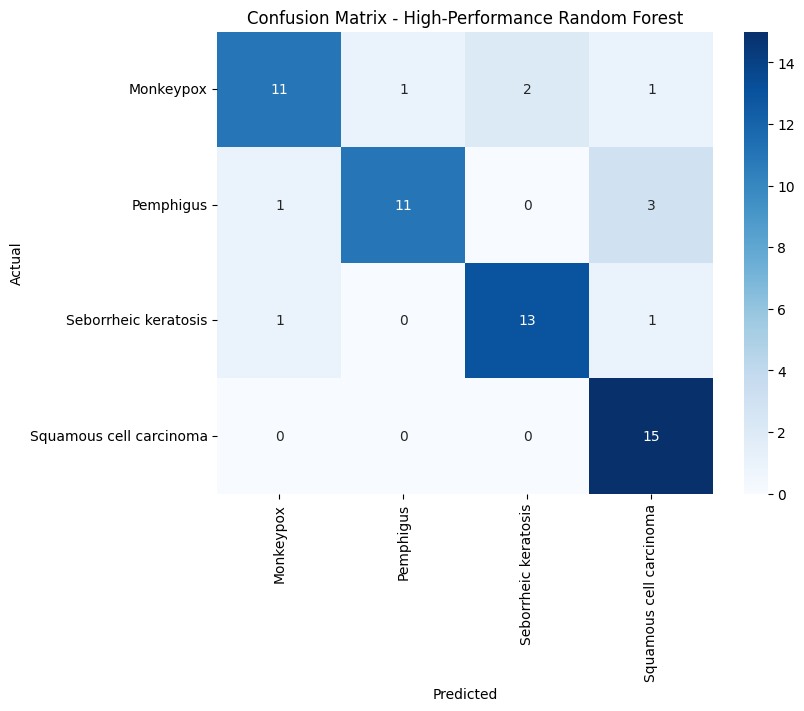

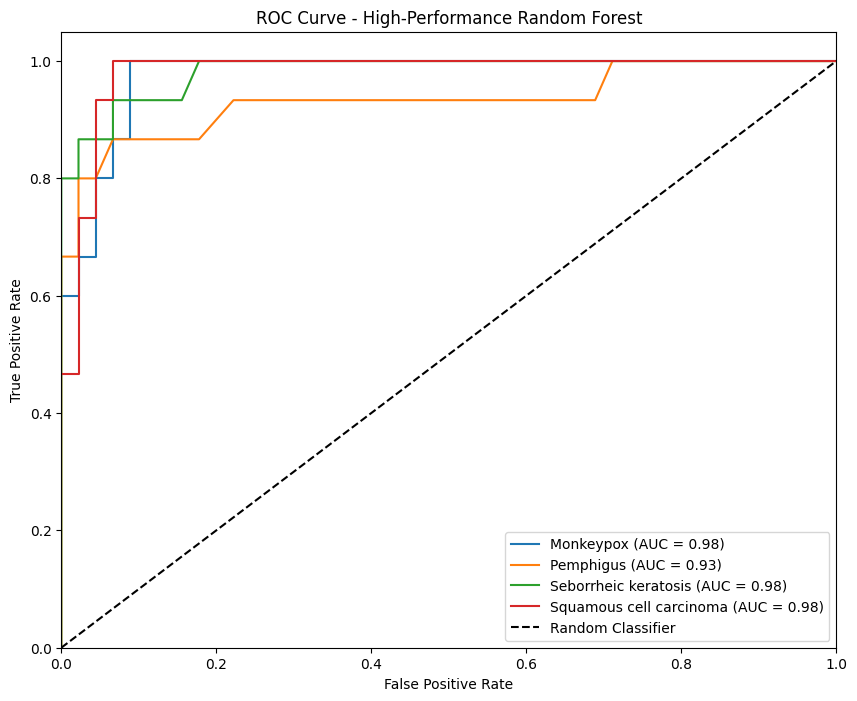

In [14]:


def train_random_forest_high_performance(X_train, y_train, X_test, y_test, label_encoder):
    """
    Train Random Forest with maximum performance parameters
    """
    print("Training High-Performance Random Forest...")
    
    # Maximum performance parameters (slower but best accuracy)
    model = RandomForestClassifier(
        n_estimators=300,  # Many trees for maximum accuracy
        max_depth=20,  # Deep trees for complex patterns
        min_samples_split=2,  # Minimum threshold for maximum flexibility
        min_samples_leaf=1,  # Smallest possible leaf nodes
        max_features='sqrt',  # Optimal for classification
        class_weight='balanced_subsample',  # Advanced balancing
        bootstrap=True,
        oob_score=True,
        max_samples=0.8,  # Use 80% of samples for each tree
        n_jobs=-1,
        random_state=42
    )
    
    print("Training with high-performance parameters:")
    print("n_estimators=300, max_depth=20, max_samples=0.8")
    print("class_weight='balanced_subsample' for advanced balancing")
    
    model.fit(X_train, y_train)
    
    print(f"Out-of-bag score: {model.oob_score_:.4f}")
    
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    accuracy, precision, recall, f1 = calculate_basic_metrics(y_test, y_pred, "High-Performance Random Forest")
    print_classification_report(y_test, y_pred, label_encoder.classes_, "High-Performance Random Forest")
    plot_confusion_matrix(y_test, y_pred, label_encoder.classes_, "High-Performance Random Forest")
    plot_roc_curve(y_test, y_pred_proba, label_encoder, "High-Performance Random Forest")
    
    return model, accuracy


rf_model, rf_accuracy = train_random_forest_high_performance(X_train, y_train_encoded, X_test, y_test_encoded, label_encoder)

# RF with Grid Search CV 

In [ ]:
from sklearn.model_selection import GridSearchCV

def train_random_forest(X_train, y_train, X_test, y_test, label_encoder):
    """
    Train Random Forest model with Grid Search CV
    """
    print("Training Random Forest with Grid Search CV...")
    
    # Define parameter grid
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }
    
    # Create base model
    rf = RandomForestClassifier(random_state=42)
    
    # Grid Search CV
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    
    # Fit grid search
    grid_search.fit(X_train, y_train)
    
    # Get best model
    model = grid_search.best_estimator_
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_:.4f}")
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    # Calculate metrics
    accuracy, precision, recall, f1 = calculate_basic_metrics(y_test, y_pred, "Random Forest")
    
    # Print classification report
    print_classification_report(y_test, y_pred, label_encoder.classes_, "Random Forest")
    
    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred, label_encoder.classes_, "Random Forest")
    
    # Plot ROC curve
    plot_roc_curve(y_test, y_pred_proba, label_encoder, "Random Forest")
    
    return model, accuracy

# Usage remains the same
rf_model, rf_accuracy = train_random_forest(X_train, y_train_encoded, X_test, y_test_encoded, label_encoder)

# CNN

Creating data generators...
Found 1536 images belonging to 4 classes.
Found 384 images belonging to 4 classes.
Found 80 images belonging to 4 classes.
Training samples: 1536
Validation samples: 384
Test samples: 80
Classes: ['Monkeypox', 'Pemphigus', 'Seborrheic keratosis', 'Squamous cell carcinoma']

Creating CNN model...
Model created with 1,440,036 parameters

Training model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.4095 - loss: 2.0412
Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to best_medical_cnn.h5
48/48 ━━━━━━━━━━━━━━━━━━━━ 45s 476ms/step - accuracy: 0.4106 - loss: 2.0385 - val_accuracy: 0.2500 - val_loss: 2.6706 - learning_rate: 0.0010
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.5105 - loss: 1.7401
Epoch 2: val_accuracy improved from 0.25000 to 0.26562, saving model to best_medical_cnn.h5
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 421ms/step - accuracy: 0.5106 - loss: 1.7404 - val_accuracy: 0.2656 - val_loss: 2.8846 - learning_rate: 0.0010
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.5983 - loss: 1.6196
Epoch 3: val_accuracy did not improve from 0.26562
48/48 ━━━━━━━━━━━━━━━━━━━━ 19s 403ms/step - accuracy: 0.5979 - loss: 1.6199 - val_accuracy: 0.2500 - val_loss: 2.5915 - learning_rate: 0.0010
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.5988 - loss: 1.585

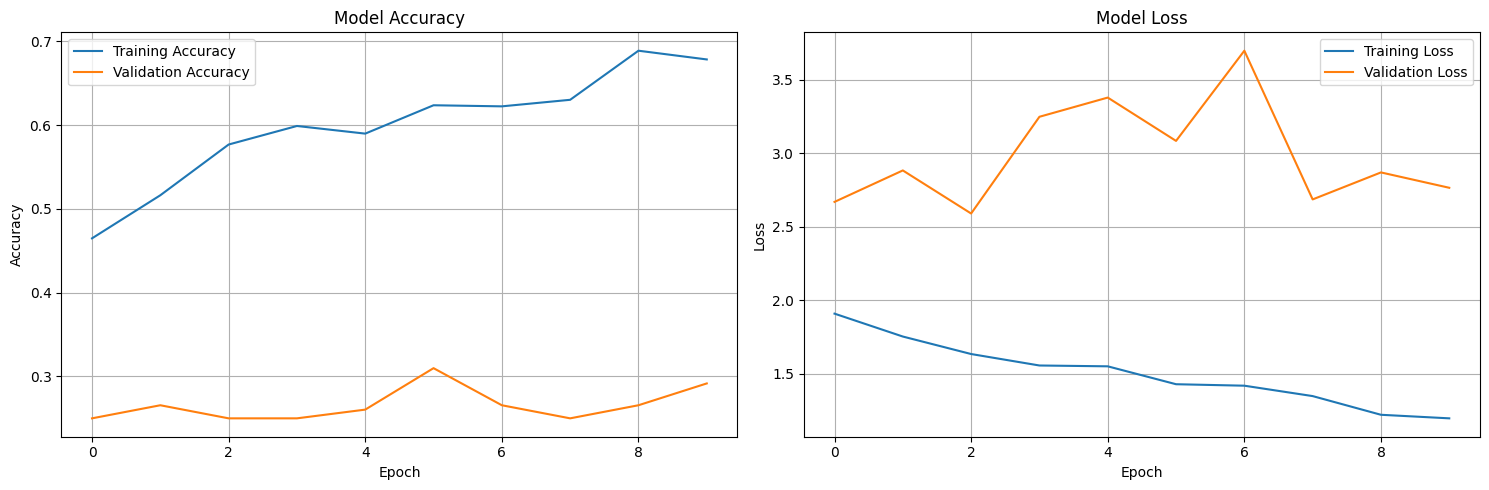


Evaluating model...
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step  

Test Accuracy: 0.3500

Classification Report:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
                         precision    recall  f1-score   support

              Monkeypox       0.00      0.00      0.00        20
              Pemphigus       0.00      0.00      0.00        20
   Seborrheic keratosis       0.52      0.60      0.56        20
Squamous cell carcinoma       0.28      0.80      0.42        20

               accuracy                           0.35        80
              macro avg       0.20      0.35      0.24        80
           weighted avg       0.20      0.35      0.24        80



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


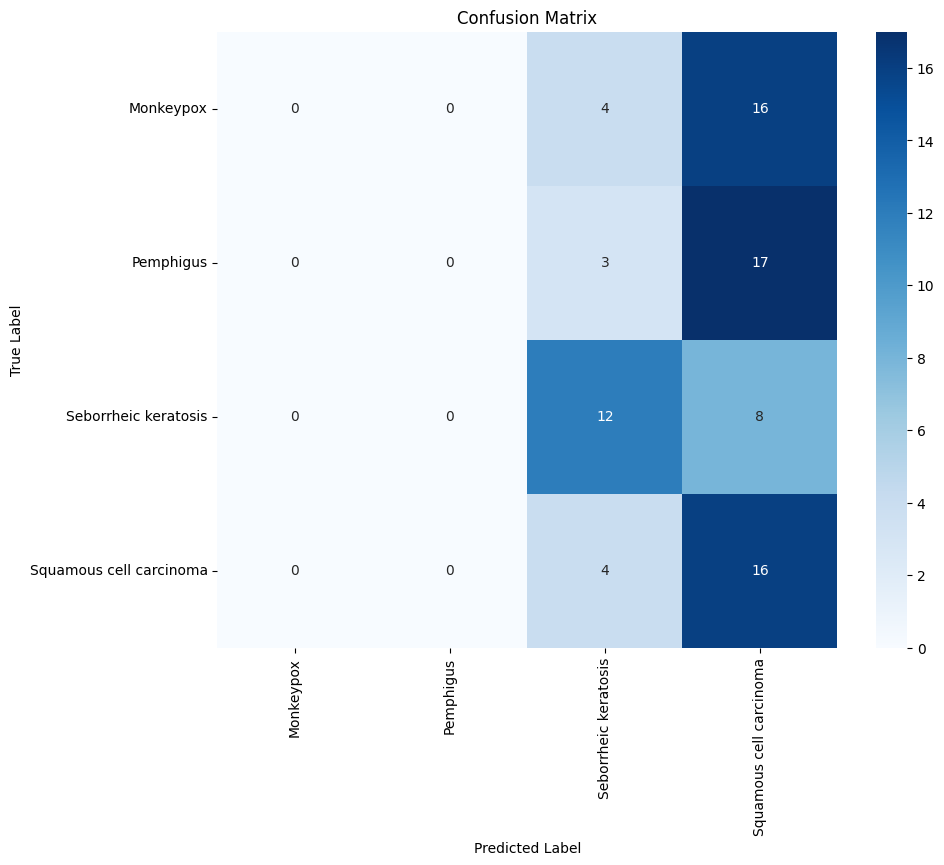


Detailed Results:
Monkeypox: Precision=0.000, Recall=0.000, F1=0.000
Pemphigus: Precision=0.000, Recall=0.000, F1=0.000
Seborrheic keratosis: Precision=0.522, Recall=0.600, F1=0.558
Squamous cell carcinoma: Precision=0.281, Recall=0.800, F1=0.416


In [9]:
# CNN Implementation for Medical Image Classification

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import pandas as pd

# ========================================================================================
# CNN MODEL ARCHITECTURES
# ========================================================================================

class MedicalCNNModels:
    def __init__(self, input_shape=(224, 224, 3), num_classes=4):
        self.input_shape = input_shape
        self.num_classes = num_classes
    
    def create_simple_cnn(self):
        """
        Simple CNN architecture for medical image classification
        """
        model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            
            Conv2D(64, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            
            Conv2D(128, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            
            Conv2D(256, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            
            GlobalAveragePooling2D(),
            Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
            Dropout(0.5),
            Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
            Dropout(0.3),
            Dense(self.num_classes, activation='softmax')
        ])
        
        return model
    
    def create_advanced_cnn(self):
        """
        More advanced CNN with residual-like connections
        """
        inputs = Input(shape=self.input_shape)
        
        # First block
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
        x = BatchNormalization()(x)
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2))(x)
        x = Dropout(0.25)(x)
        
        # Second block
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2))(x)
        x = Dropout(0.25)(x)
        
        # Third block
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2))(x)
        x = Dropout(0.25)(x)
        
        # Fourth block
        x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2))(x)
        x = Dropout(0.25)(x)
        
        # Global pooling and dense layers
        x = GlobalAveragePooling2D()(x)
        x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
        x = Dropout(0.5)(x)
        x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
        x = Dropout(0.3)(x)
        outputs = Dense(self.num_classes, activation='softmax')(x)
        
        model = Model(inputs, outputs)
        return model

# ========================================================================================
# DATA GENERATORS
# ========================================================================================

class DataGenerators:
    def __init__(self, train_dir, test_dir, img_size=(224, 224), batch_size=32):
        self.train_dir = train_dir
        self.test_dir = test_dir
        self.img_size = img_size
        self.batch_size = batch_size
        
    def create_generators(self):
        """
        Create data generators for training and testing
        """
        # Training data generator with augmentation
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest',
            validation_split=0.2  # 20% for validation
        )
        
        # Test data generator (only rescaling)
        test_datagen = ImageDataGenerator(rescale=1./255)
        
        # Training generator
        train_generator = train_datagen.flow_from_directory(
            self.train_dir,
            target_size=self.img_size,
            batch_size=self.batch_size,
            class_mode='categorical',
            subset='training'
        )
        
        # Validation generator
        validation_generator = train_datagen.flow_from_directory(
            self.train_dir,
            target_size=self.img_size,
            batch_size=self.batch_size,
            class_mode='categorical',
            subset='validation'
        )
        
        # Test generator
        test_generator = test_datagen.flow_from_directory(
            self.test_dir,
            target_size=self.img_size,
            batch_size=self.batch_size,
            class_mode='categorical',
            shuffle=False
        )
        
        return train_generator, validation_generator, test_generator

# ========================================================================================
# TRAINING AND EVALUATION
# ========================================================================================

class CNNTrainer:
    def __init__(self, model, train_generator, validation_generator, test_generator):
        self.model = model
        self.train_generator = train_generator
        self.validation_generator = validation_generator
        self.test_generator = test_generator
        
    def compile_model(self, learning_rate=0.001):
        """
        Compile the model with optimizer and loss function
        """
        self.model.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
    def train_model(self, epochs=50, save_path='best_model.h5'):
        """
        Train the CNN model with callbacks
        """
        # Callbacks
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
        
        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=0.0001
        )
        
        model_checkpoint = ModelCheckpoint(
            save_path,
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
        
        # Train the model
        history = self.model.fit(
            self.train_generator,
            steps_per_epoch=len(self.train_generator),
            epochs=epochs,
            validation_data=self.validation_generator,
            validation_steps=len(self.validation_generator),
            callbacks=[early_stopping, reduce_lr, model_checkpoint],
            verbose=1
        )
        
        return history
    
    def evaluate_model(self):
        """
        Evaluate the model on test data
        """
        # Predictions
        predictions = self.model.predict(self.test_generator, verbose=1)
        predicted_classes = np.argmax(predictions, axis=1)
        
        # True labels
        true_classes = self.test_generator.classes
        class_labels = list(self.test_generator.class_indices.keys())
        
        # Calculate metrics
        accuracy = accuracy_score(true_classes, predicted_classes)
        
        # Classification report
        report = classification_report(
            true_classes, predicted_classes,
            target_names=class_labels,
            output_dict=True
        )
        
        # Confusion matrix
        cm = confusion_matrix(true_classes, predicted_classes)
        
        return accuracy, report, cm, class_labels
    
    def plot_training_history(self, history):
        """
        Plot training history
        """
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        # Accuracy plot
        axes[0].plot(history.history['accuracy'], label='Training Accuracy')
        axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
        axes[0].set_title('Model Accuracy')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Accuracy')
        axes[0].legend()
        axes[0].grid(True)
        
        # Loss plot
        axes[1].plot(history.history['loss'], label='Training Loss')
        axes[1].plot(history.history['val_loss'], label='Validation Loss')
        axes[1].set_title('Model Loss')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Loss')
        axes[1].legend()
        axes[1].grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def plot_confusion_matrix(self, cm, class_labels):
        """
        Plot confusion matrix
        """
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_labels, yticklabels=class_labels)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

# ========================================================================================
# MAIN EXECUTION
# ========================================================================================

def main():
    # Define paths (use the same paths from your existing code)
    augmented_train_path = "/kaggle/working/augmented_train_dataset"
    test_path = "/kaggle/working/test_dataset"
    
    # Create data generators
    print("Creating data generators...")
    data_gen = DataGenerators(augmented_train_path, test_path)
    train_gen, val_gen, test_gen = data_gen.create_generators()
    
    print(f"Training samples: {train_gen.samples}")
    print(f"Validation samples: {val_gen.samples}")
    print(f"Test samples: {test_gen.samples}")
    print(f"Classes: {list(train_gen.class_indices.keys())}")
    
    # Create and compile model
    print("\nCreating CNN model...")
    model_builder = MedicalCNNModels(num_classes=4)
    
    # Choose between simple or advanced CNN
    model = model_builder.create_advanced_cnn()  # or create_simple_cnn()
    
    print(f"Model created with {model.count_params():,} parameters")
    
    # Create trainer
    trainer = CNNTrainer(model, train_gen, val_gen, test_gen)
    trainer.compile_model(learning_rate=0.001)
    
    # Train model
    print("\nTraining model...")
    history = trainer.train_model(epochs=10, save_path='best_medical_cnn.h5')
    
    # Plot training history
    trainer.plot_training_history(history)
    
    # Load best model and evaluate
    print("\nEvaluating model...")
    model.load_weights('best_medical_cnn.h5')
    
    accuracy, report, cm, class_labels = trainer.evaluate_model()
    
    print(f"\nTest Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(test_gen.classes, 
                              np.argmax(model.predict(test_gen), axis=1),
                              target_names=class_labels))
    
    # Plot confusion matrix
    trainer.plot_confusion_matrix(cm, class_labels)
    
    # Print detailed results
    print("\nDetailed Results:")
    for class_name in class_labels:
        precision = report[class_name]['precision']
        recall = report[class_name]['recall']
        f1 = report[class_name]['f1-score']
        print(f"{class_name}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")

if __name__ == "__main__":
    main()

# CNN version : 2 

🏥 MEDICAL IMAGE CLASSIFICATION WITH CNN
Setting up data generators...
Found 544 images belonging to 4 classes.
Found 136 images belonging to 4 classes.
Found 60 images belonging to 4 classes.
✓ Training samples: 544
✓ Validation samples: 136
✓ Test samples: 60
✓ Classes: ['Monkeypox', 'Pemphigus', 'Seborrheic keratosis', 'Squamous cell carcinoma']

CREATING AND TRAINING CNN MODEL
✓ Model created with 11,170,372 parameters
Training Configuration:
- Epochs: 15
- Steps per epoch: 17
- Validation steps: 5
- Total training steps: 330
--------------------------------------------------
Starting training...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 518ms/step - accuracy: 0.3696 - loss: 23.8945 - val_accuracy: 0.2500 - val_loss: 11.1458 - learning_rate: 0.0010
Epoch 2/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 403ms/step - accuracy: 0.4845 - loss: 16.9195 - val_accuracy: 0.2500 - val_loss: 13.6610 - learning_rate: 0.0010
Epoch 3/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 396ms/step - accuracy: 0.4528 - loss: 13.2315 - val_accuracy: 0.2500 - val_loss: 29.1299 - learning_rate: 0.0010
Epoch 4/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.4704 - loss: 7.7648
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 402ms/step - accuracy: 0.4678 - loss: 7.7049 - val_accuracy: 0.2500 - val_loss: 39.9892 - learning_rate: 0.0010
Epoch 5/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 397ms/step - accuracy: 0.4416 - loss: 3.3796 - val_accuracy: 0.2500 - val_loss: 40.0735 - learning_rate: 5.0000e-04
Epoch 6/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 389ms/step - accuracy: 0.4575 - los

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


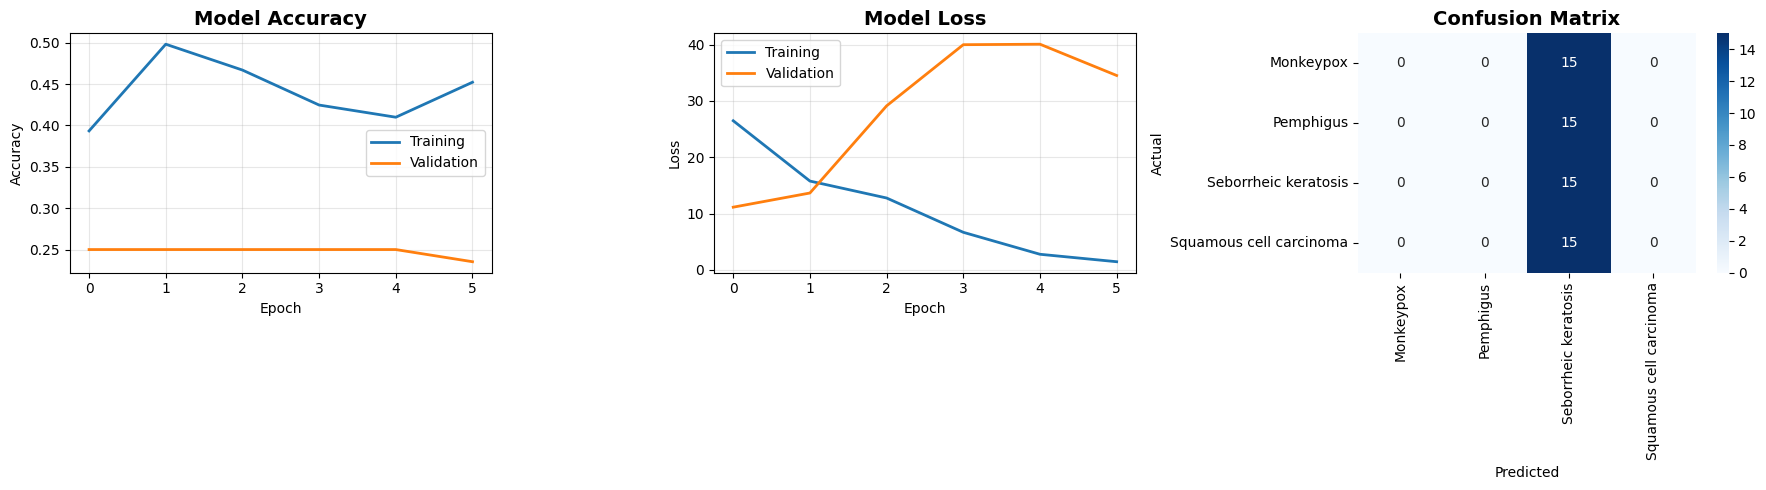


FINAL RESULTS SUMMARY
✓ Final Test Accuracy: 0.2500 (25.0%)
✓ Total Epochs Trained: 6
✓ Model Parameters: 11,170,372
✓ Classes: Monkeypox, Pemphigus, Seborrheic keratosis, Squamous cell carcinoma


In [32]:
# Simple CNN Implementation for Medical Image Classification

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import time

# ========================================================================================
# PROGRESS LOGGING (Can be easily removed)
# ========================================================================================

def log_training_progress(epochs, steps_per_epoch, validation_steps):
    """Log training configuration - easily removable"""
    total_steps = epochs * (steps_per_epoch + validation_steps)
    print(f"Training Configuration:")
    print(f"- Epochs: {epochs}")
    print(f"- Steps per epoch: {steps_per_epoch}")
    print(f"- Validation steps: {validation_steps}")
    print(f"- Total training steps: {total_steps}")
    print("-" * 50)

# ========================================================================================
# SIMPLE CNN MODEL
# ========================================================================================

def create_simple_cnn(input_shape=(224, 224, 3), num_classes=4):
    """
    Create a simple but effective CNN model
    """
    model = Sequential([
        # First Conv Block
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        # Second Conv Block
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        # Third Conv Block
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        # Flatten and Dense layers
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# ========================================================================================
# DATA PREPARATION
# ========================================================================================

def create_data_generators(train_dir, test_dir, img_size=(224, 224), batch_size=32):
    """
    Create simple data generators
    """
    print("Setting up data generators...")
    
    # Training data with basic augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        validation_split=0.2
    )
    
    # Test data (only rescaling)
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    # Create generators
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )
    
    validation_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )
    
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    
    print(f"✓ Training samples: {train_generator.samples}")
    print(f"✓ Validation samples: {validation_generator.samples}")
    print(f"✓ Test samples: {test_generator.samples}")
    print(f"✓ Classes: {list(train_generator.class_indices.keys())}")
    
    return train_generator, validation_generator, test_generator

# ========================================================================================
# TRAINING FUNCTION
# ========================================================================================

def train_cnn_model(train_generator, validation_generator, epochs=15):
    """
    Train CNN model with progress tracking
    """
    print("\n" + "="*60)
    print("CREATING AND TRAINING CNN MODEL")
    print("="*60)
    
    # Create model
    model = create_simple_cnn(num_classes=len(train_generator.class_indices))
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    print(f"✓ Model created with {model.count_params():,} parameters")
    
    # Log training progress
    log_training_progress(epochs, len(train_generator), len(validation_generator))
    
    # Setup callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=0.0001,
        verbose=1
    )
    
    # Start training
    print("Starting training...")
    start_time = time.time()
    
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    end_time = time.time()
    training_time = end_time - start_time
    
    print(f"\n✓ Training completed in {training_time/60:.1f} minutes")
    
    return model, history

# ========================================================================================
# EVALUATION FUNCTIONS
# ========================================================================================

def evaluate_model(model, test_generator):
    """
    Evaluate model and return metrics
    """
    print("\n" + "="*60)
    print("MODEL EVALUATION")
    print("="*60)
    
    # Make predictions
    print("Making predictions...")
    predictions = model.predict(test_generator, verbose=1)
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Get true labels
    true_classes = test_generator.classes
    class_names = list(test_generator.class_indices.keys())
    
    # Calculate accuracy
    accuracy = np.mean(predicted_classes == true_classes)
    
    print(f"\n✓ Test Accuracy: {accuracy:.4f}")
    
    # Classification report
    report = classification_report(
        true_classes, 
        predicted_classes, 
        target_names=class_names
    )
    print("\nClassification Report:")
    print(report)
    
    # Confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    
    return accuracy, cm, class_names

def plot_results(history, cm, class_names):
    """
    Plot training history and confusion matrix
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Training accuracy
    axes[0].plot(history.history['accuracy'], label='Training', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Training loss
    axes[1].plot(history.history['loss'], label='Training', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Validation', linewidth=2)
    axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=axes[2])
    axes[2].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
    axes[2].set_xlabel('Predicted')
    axes[2].set_ylabel('Actual')
    
    plt.tight_layout()
    plt.show()

# ========================================================================================
# MAIN EXECUTION
# ========================================================================================

def main():
    """
    Main function to run the complete CNN pipeline
    """
    print("🏥 MEDICAL IMAGE CLASSIFICATION WITH CNN")
    print("="*60)
    
    # Define paths
    train_dir = "/kaggle/working/augmented_train_dataset_new_new_new"
    test_dir = "/kaggle/working/test_dataset_new_new_new"
    
    # Step 1: Create data generators
    train_gen, val_gen, test_gen = create_data_generators(train_dir, test_dir)
    
    # Step 2: Train model
    model, history = train_cnn_model(train_gen, val_gen, epochs=15)
    
    # Step 3: Evaluate model
    accuracy, cm, class_names = evaluate_model(model, test_gen)
    
    # Step 4: Plot results
    plot_results(history, cm, class_names)
    
    # Step 5: Print summary
    print("\n" + "="*60)
    print("FINAL RESULTS SUMMARY")
    print("="*60)
    print(f"✓ Final Test Accuracy: {accuracy:.4f} ({accuracy*100:.1f}%)")
    print(f"✓ Total Epochs Trained: {len(history.history['accuracy'])}")
    print(f"✓ Model Parameters: {model.count_params():,}")
    print(f"✓ Classes: {', '.join(class_names)}")
    
    return model, history, accuracy

# Run the complete pipeline
if __name__ == "__main__":
    model, history, final_accuracy = main()

# CNN 3

In [15]:
# IMPROVED CNN WITH FIXES FOR YOUR ISSUES

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import numpy as np

# ========================================================================================
# SOLUTION 1: IMPROVED MODEL ARCHITECTURE
# ========================================================================================

def create_improved_cnn(input_shape=(224, 224, 3), num_classes=4):
    """
    Improved CNN with better architecture to prevent overfitting
    """
    model = Sequential([
        # First block - smaller filters, more regularization
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Second block
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Third block
        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Global Average Pooling instead of Flatten (reduces overfitting)
        GlobalAveragePooling2D(),
        
        # Smaller dense layer
        Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.3),

        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.3),


        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.3),

        Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.3),

        
        Dense(num_classes, activation='softmax') #output

        
    ])
    
    return model

# ========================================================================================
# SOLUTION 2: BETTER DATA AUGMENTATION
# ========================================================================================

def create_improved_data_generators(train_dir, test_dir, img_size=(224, 224), batch_size=16):
    """
    Improved data generators with better augmentation and smaller batch size
    """
    print("Setting up improved data generators...")
    
    # More aggressive augmentation for small dataset
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.2
    )
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    # Smaller batch size for small dataset
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,  # Reduced from 32 to 16
        class_mode='categorical',
        subset='training',
        shuffle=True
    )
    
    validation_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        shuffle=True
    )
    
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    
    # Check class distribution
    
    print(f"✓ Training samples: {train_generator.samples}")
    print(f"✓ Validation samples: {validation_generator.samples}")
    print(f"✓ Test samples: {test_generator.samples}")
    print(f"✓ Classes: {list(train_generator.class_indices.keys())}")
    
    # Print class distribution
    print("Class distribution in training:")
    unique, counts = np.unique(train_generator.classes, return_counts=True)
    for i, (class_idx, count) in enumerate(zip(unique, counts)):
        class_name = list(train_generator.class_indices.keys())[class_idx]
        print(f"  {class_name}: {count} samples")
    
    return train_generator, validation_generator, test_generator

# ========================================================================================
# SOLUTION 3: BETTER TRAINING CONFIGURATION
# ========================================================================================

def train_improved_cnn(train_generator, validation_generator, epochs=50):
    """
    Improved training with better hyperparameters
    """
    print("\n" + "="*60)
    print("TRAINING IMPROVED CNN MODEL")
    print("="*60)
    
    # Create improved model
    model = create_improved_cnn(num_classes=len(train_generator.class_indices))
    
    # Calculate class weights to handle imbalance
    class_weights = {}
    unique, counts = np.unique(train_generator.classes, return_counts=True)
    total_samples = sum(counts)
    
    for i, count in enumerate(counts):
        class_weights[i] = total_samples / (len(counts) * count)
    
    print(f"Class weights: {class_weights}")
    
    # Compile with lower learning rate
    model.compile(
        optimizer=Adam(learning_rate=0.0001),  # Lower learning rate
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    print(f"✓ Model created with {model.count_params():,} parameters")
    
    # Better callbacks
    early_stopping = EarlyStopping(
        monitor='val_accuracy',  # Monitor accuracy instead of loss
        patience=10,  # More patience
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=5,
        min_lr=0.00001,
        verbose=1
    )
    
    # Train with class weights
    
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        callbacks=[early_stopping, reduce_lr],
        class_weight=class_weights,  # Handle class imbalance
        verbose=1
    )
    
    return model, history

# ========================================================================================
# SOLUTION 4: TRANSFER LEARNING APPROACH
# ========================================================================================

def create_transfer_learning_model(input_shape=(224, 224, 3), num_classes=4):
    """
    Use transfer learning for better performance with small dataset
    """
    # Load pre-trained model
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    
    # Freeze base model initially
    base_model.trainable = False
    
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

def train_transfer_learning_model(train_generator, validation_generator, epochs=50):
    """
    Train using transfer learning
    """
    print("Training with Transfer Learning...")
    
    model = create_transfer_learning_model(num_classes=len(train_generator.class_indices))
    
    # Calculate class weights
    unique, counts = np.unique(train_generator.classes, return_counts=True)
    total_samples = sum(counts)
    class_weights = {i: total_samples / (len(counts) * count) for i, count in enumerate(counts)}
    
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    ) 
    
    callbacks = [
        EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=4, min_lr=0.00001, verbose=1)
    ]
    
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )
    
    return model, history

# ========================================================================================
# USAGE EXAMPLES
# ========================================================================================

# Define your dataset paths
train_dir = "/kaggle/working/augmented_train_dataset_new_new_new"
test_dir = "/kaggle/working/test_dataset_new_new_new"

# Option 1: Use improved CNN
# train_gen, val_gen, test_gen = create_improved_data_generators(train_dir, test_dir)
# model, history = train_improved_cnn(train_gen, val_gen, epochs=30)

# Option 2: Use transfer learning (RECOMMENDED for small datasets)
train_gen, val_gen, test_gen = create_improved_data_generators(train_dir, test_dir)


model, history = train_transfer_learning_model(train_gen, val_gen, epochs=50)

Setting up improved data generators...
Found 544 images belonging to 4 classes.
Found 136 images belonging to 4 classes.
Found 60 images belonging to 4 classes.
✓ Training samples: 544
✓ Validation samples: 136
✓ Test samples: 60
✓ Classes: ['Monkeypox', 'Pemphigus', 'Seborrheic keratosis', 'Squamous cell carcinoma']
Class distribution in training:
  Monkeypox: 136 samples
  Pemphigus: 136 samples
  Seborrheic keratosis: 136 samples
  Squamous cell carcinoma: 136 samples
Training with Transfer Learning...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 24s 387ms/step - accuracy: 0.2256 - loss: 2.1817 - val_accuracy: 0.3529 - val_loss: 1.3071 - learning_rate: 1.0000e-04
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 209ms/step - accuracy: 0.3088 - loss: 1.8878 - val_accuracy: 0.4632 - val_loss: 1.2418 - learning_rate: 1.0000e-04
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 207ms/step - accuracy: 0.3736 - loss: 1.5883 - val_accuracy: 0.5000 - val_loss: 1.1995 - learning_rate: 1.0000e-04
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 213ms/step - accuracy: 0.3890 - loss: 1.5847 - val_accuracy: 0.5294 - val_loss: 1.1323 - learning_rate: 1.0000e-04
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 210ms/step - accuracy: 0.4513 - loss: 1.2983 - val_accuracy: 0.5735 - val_loss: 1.0819 - learning_rate: 1.0000e-04
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 209ms/step - accuracy: 0.4503 - loss: 1.3234 - val_accuracy: 0.6176 - val_loss: 1.0374 - learning_rate: 1.0000e-04
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 208ms/step - accuracy:

# Main function 

In [ ]:
# ========================================================================================
# MAIN EXECUTION FUNCTION
# ========================================================================================

def main():
    """
    Main function to run the complete pipeline
    """
    # Define paths
    original_path = "/kaggle/input/four-diseases-dataset/Dataset"
    train_path = "/kaggle/working/train_dataset"
    test_path = "/kaggle/working/test_dataset"
    augmented_train_path = "/kaggle/working/augmented_train_dataset"
    
    # Step 1: Split original dataset
    print("Step 1: Splitting original dataset...")
    split_original_dataset(original_path, train_path, test_path)
    
    # Step 2: Augment training data
    print("\nStep 2: Augmenting training data...")
    augment_training_data(train_path, augmented_train_path)
    
    # Step 3: Extract features
    print("\nStep 3: Extracting features...")
    feature_extractor = FeatureExtractor()
    
    # Extract training features
    X_train, y_train = feature_extractor.extract_features_batch(augmented_train_path)
    
    # Extract test features
    X_test, y_test = feature_extractor.extract_features_batch(test_path)
    
    # Step 4: Encode labels
    print("\nStep 4: Encoding labels...")
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    
    print(f"Training features shape: {X_train.shape}")
    print(f"Test features shape: {X_test.shape}")
    print(f"Classes: {label_encoder.classes_}")
    
    # Step 5: Train all models
    print("\nStep 5: Training all models...")
    
    models = {}
    accuracies = {}
    
    # K-Nearest Neighbors
    knn_model, knn_accuracy = train_knn(X_train, y_train_encoded, X_test, y_test_encoded, label_encoder)
    models['K-Nearest Neighbors'] = knn_model
    accuracies['K-Nearest Neighbors'] = knn_accuracy
    
    # Logistic Regression
    lr_model, lr_accuracy = train_logistic_regression(X_train, y_train_encoded, X_test, y_test_encoded, label_encoder)
    models['Logistic Regression'] = lr_model
    accuracies['Logistic Regression'] = lr_accuracy
    
    # Support Vector Machine
    svm_model, svm_accuracy = train_svm(X_train, y_train_encoded, X_test, y_test_encoded, label_encoder)
    models['Support Vector Machine'] = svm_model
    accuracies['Support Vector Machine'] = svm_accuracy
    
    # Decision Tree
    dt_model, dt_accuracy = train_decision_tree(X_train, y_train_encoded, X_test, y_test_encoded, label_encoder)
    models['Decision Tree'] = dt_model
    accuracies['Decision Tree'] = dt_accuracy
    
    # Random Forest
    rf_model, rf_accuracy = train_random_forest(X_train, y_train_encoded, X_test, y_test_encoded, label_encoder)
    models['Random Forest'] = rf_model
    accuracies['Random Forest'] = rf_accuracy
    
    # Step 6: Compare all models
    print("\n" + "="*50)
    print("MODEL COMPARISON")
    print("="*50)
    
    accuracy_df = pd.DataFrame(list(accuracies.items()), columns=['Model', 'Accuracy'])
    accuracy_df = accuracy_df.sort_values('Accuracy', ascending=False)
    
    print(accuracy_df.to_string(index=False))
    
    # Plot accuracy comparison
    plt.figure(figsize=(10, 6))
    plt.bar(accuracy_df['Model'], accuracy_df['Accuracy'])
    plt.title('Model Accuracy Comparison')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Save best model
    best_model_name = accuracy_df.iloc[0]['Model']
    best_model = models[best_model_name]
    
    print(f"\nBest performing model: {best_model_name}")
    print(f"Best accuracy: {accuracy_df.iloc[0]['Accuracy']:.4f}")
    
    # Save the best model
    with open('/kaggle/working/best_model.pkl', 'wb') as f:
        pickle.dump(best_model, f)
    
    with open('/kaggle/working/label_encoder.pkl', 'wb') as f:
        pickle.dump(label_encoder, f)
    
    print("\nModels saved successfully!")

# ========================================================================================
# RUN THE PROGRAM
# ========================================================================================

if __name__ == "__main__":
    main()